In [1]:
# Cell 1: Import all required libraries
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Set up visualization settings
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

# Set font sizes
font_size = 12
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

# Global parameters
random_state = 42
scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

print('✔️ All libraries imported and parameters set!')

✔️ All libraries imported and parameters set!


In [2]:
# Cell 2: Load the dataset
start_time = time.time()

try:
    # Load the dataset
    df = pd.read_csv('Churn_Modelling.csv')
    
    print('✔️ Dataset Imported Successfully!')
    print(f'It contains {df.shape[0]} rows and {df.shape[1]} columns.')
    
    # Display basic info
    print("\nFirst few rows:")
    display(df.head())
    
    print("\nDataset Info:")
    df.info()
    
    print("\nDescriptive Statistics:")
    display(df.describe().T)

except FileNotFoundError:
    print("❌ Error: 'Churn_Modelling.csv' not found!")
    print("Creating a sample dataset for demonstration...")
    
    # Create a sample dataset
    np.random.seed(random_state)
    n_samples = 10000
    
    sample_data = {
        'RowNumber': range(1, n_samples + 1),
        'CustomerId': np.random.randint(10000000, 99999999, n_samples),
        'Surname': ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Miller', 'Davis', 'Rodriguez', 'Martinez'] * (n_samples // 10),
        'CreditScore': np.random.randint(350, 850, n_samples),
        'Geography': np.random.choice(['France', 'Germany', 'Spain'], n_samples),
        'Gender': np.random.choice(['Male', 'Female'], n_samples),
        'Age': np.random.randint(18, 92, n_samples),
        'Tenure': np.random.randint(0, 11, n_samples),
        'Balance': np.random.uniform(0, 250000, n_samples),
        'NumOfProducts': np.random.randint(1, 5, n_samples),
        'HasCrCard': np.random.randint(0, 2, n_samples),
        'IsActiveMember': np.random.randint(0, 2, n_samples),
        'EstimatedSalary': np.random.uniform(10000, 200000, n_samples),
        'Exited': np.random.binomial(1, 0.2, n_samples)  # 20% churn rate
    }
    
    df = pd.DataFrame(sample_data)
    print(f"Created sample dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
    display(df.head())

end_time = time.time()
print(f"\nData loading time: {end_time - start_time:.4f} seconds")

✔️ Dataset Imported Successfully!
It contains 10000 rows and 14 columns.

First few rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48



Data loading time: 0.4014 seconds


In [3]:
# Cell 3: Data preprocessing
print("DATA PREPROCESSING")
print("=" * 50)

# Remove irrelevant columns
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print(f"Original columns: {df.shape[1]}")
print(f"Columns after cleaning: {df_clean.shape[1]}")
print(f"Removed columns: {columns_to_drop}")
print(f"\nRemaining columns: {df_clean.columns.tolist()}")

# Check for missing values
print("\nMissing values check:")
missing_values = df_clean.isnull().sum()
if missing_values.sum() == 0:
    print("✓ No missing values found!")
else:
    print("Missing values found:")
    print(missing_values[missing_values > 0])

# Create train-test split
if 'Exited' in df_clean.columns:
    train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=random_state, 
                                         stratify=df_clean['Exited'])
else:
    train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f"\nTrain set: {train_df.shape[0]} rows x {train_df.shape[1]} columns")
print(f"Test set: {test_df.shape[0]} rows x {test_df.shape[1]} columns")

# Separate churned and retained customers
if 'Exited' in train_df.columns:
    df_churned = train_df[train_df['Exited'] == 1].copy()
    df_retained = train_df[train_df['Exited'] == 0].copy()

    churn_rate = len(df_churned) / len(train_df) * 100
    print(f"\nTraining set breakdown:")
    print(f"  Retained customers: {len(df_retained)} ({100 - churn_rate:.1f}%)")
    print(f"  Churned customers: {len(df_churned)} ({churn_rate:.1f}%)")
else:
    print("\nNote: 'Exited' column not found in data.")

DATA PREPROCESSING
Original columns: 14
Columns after cleaning: 11
Removed columns: ['RowNumber', 'CustomerId', 'Surname']

Remaining columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Missing values check:
✓ No missing values found!

Train set: 8000 rows x 11 columns
Test set: 2000 rows x 11 columns

Training set breakdown:
  Retained customers: 6370 (79.6%)
  Churned customers: 1630 (20.4%)


In [4]:
# Cell 4: Define visualization functions
def plot_continuous(feature, train_data, churned_data=None, retained_data=None, colors=['#00A5E0', '#DD403A']):
    """
    Plot a histogram and boxplot for the churned and retained distributions for the specified feature.
    """
    # Check if we have separate churned/retained data
    if churned_data is None or retained_data is None:
        # Create them from train_data if Exited column exists
        if 'Exited' in train_data.columns:
            churned_data = train_data[train_data['Exited'] == 1].copy()
            retained_data = train_data[train_data['Exited'] == 0].copy()
        else:
            print(f"Error: 'Exited' column not found in data for feature '{feature}'")
            return
    
    # Check if feature exists in data
    if feature not in train_data.columns:
        print(f"Error: Feature '{feature}' not found in data")
        return
    
    # Create a copy of the training dataframe
    df_func = train_data.copy()
    if 'Exited' in df_func.columns:
        df_func['Exited'] = df_func['Exited'].astype('category')
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), sharex=True, 
                                   gridspec_kw={'height_ratios': (.7, .3)})
    
    # Histograms for both categories
    for data, color, label in zip([retained_data, churned_data], colors, ['Retained', 'Churned']):
        sns.histplot(data=data, x=feature, bins=20, color=color, alpha=0.6,
                     edgecolor='black', label=label, kde=True, ax=ax1)
    ax1.legend()
    ax1.set_ylabel('Count')
    ax1.set_title(f'Distribution of {feature} by Churn Status')
    
    # Boxplot
    if 'Exited' in df_func.columns:
        sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_yticklabels(['Retained', 'Churned'])
    else:
        # If no Exited column, create boxplot manually
        box_data = [retained_data[feature].dropna(), churned_data[feature].dropna()]
        ax2.boxplot(box_data, labels=['Retained', 'Churned'], patch_artist=True)
        ax2.set_ylabel('Churn Status')
    
    ax2.set_xlabel(feature)
    
    plt.tight_layout()
    plt.show()

def plot_categorical(feature, train_data, colors=['#00A5E0', '#DD403A']):
    """
    For a categorical feature, plot countplot and churn rate barplot.
    """
    if 'Exited' not in train_data.columns:
        print(f"Cannot plot: 'Exited' column not found in data")
        return
    
    if feature not in train_data.columns:
        print(f"Error: Feature '{feature}' not found in data")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Countplot
    sns.countplot(x=feature, hue='Exited', data=train_data, palette=colors, ax=ax1)
    ax1.set_ylabel('Count')
    ax1.set_xlabel(feature)
    ax1.set_title(f'Count of {feature} by Churn Status')
    ax1.legend(title='Churn Status', labels=['Retained', 'Churned'])
    
    # Calculate churn rates
    churn_rate = train_data.groupby(feature)['Exited'].mean().reset_index()
    churn_rate.columns = [feature, 'Churn Rate']
    
    # Barplot for churn rate
    sns.barplot(x=feature, y='Exited', data=train_data, palette='viridis', ax=ax2, errorbar=None)
    ax2.set_ylabel('Churn Rate')
    ax2.set_xlabel(feature)
    ax2.set_title(f'Churn Rate by {feature}')
    ax2.set_ylim(0, 1)
    
    # Add percentage labels
    for i, rate in enumerate(churn_rate['Churn Rate']):
        ax2.text(i, rate + 0.02, f'{rate:.1%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, ax, title='Confusion Matrix'):
    """
    Plot a confusion matrix in the specified axes object.
    """
    # Normalize the confusion matrix for percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(data=cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                annot_kws={'fontsize': 12}, ax=ax, cbar=False)
    
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])
    
    ax.set_ylabel('True Label')
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['Retained', 'Churned'])
    ax.set_title(title)

print('✔️ Visualization functions defined!')

✔️ Visualization functions defined!


DATA VISUALIZATION EXAMPLES

1. Age Distribution by Churn Status:


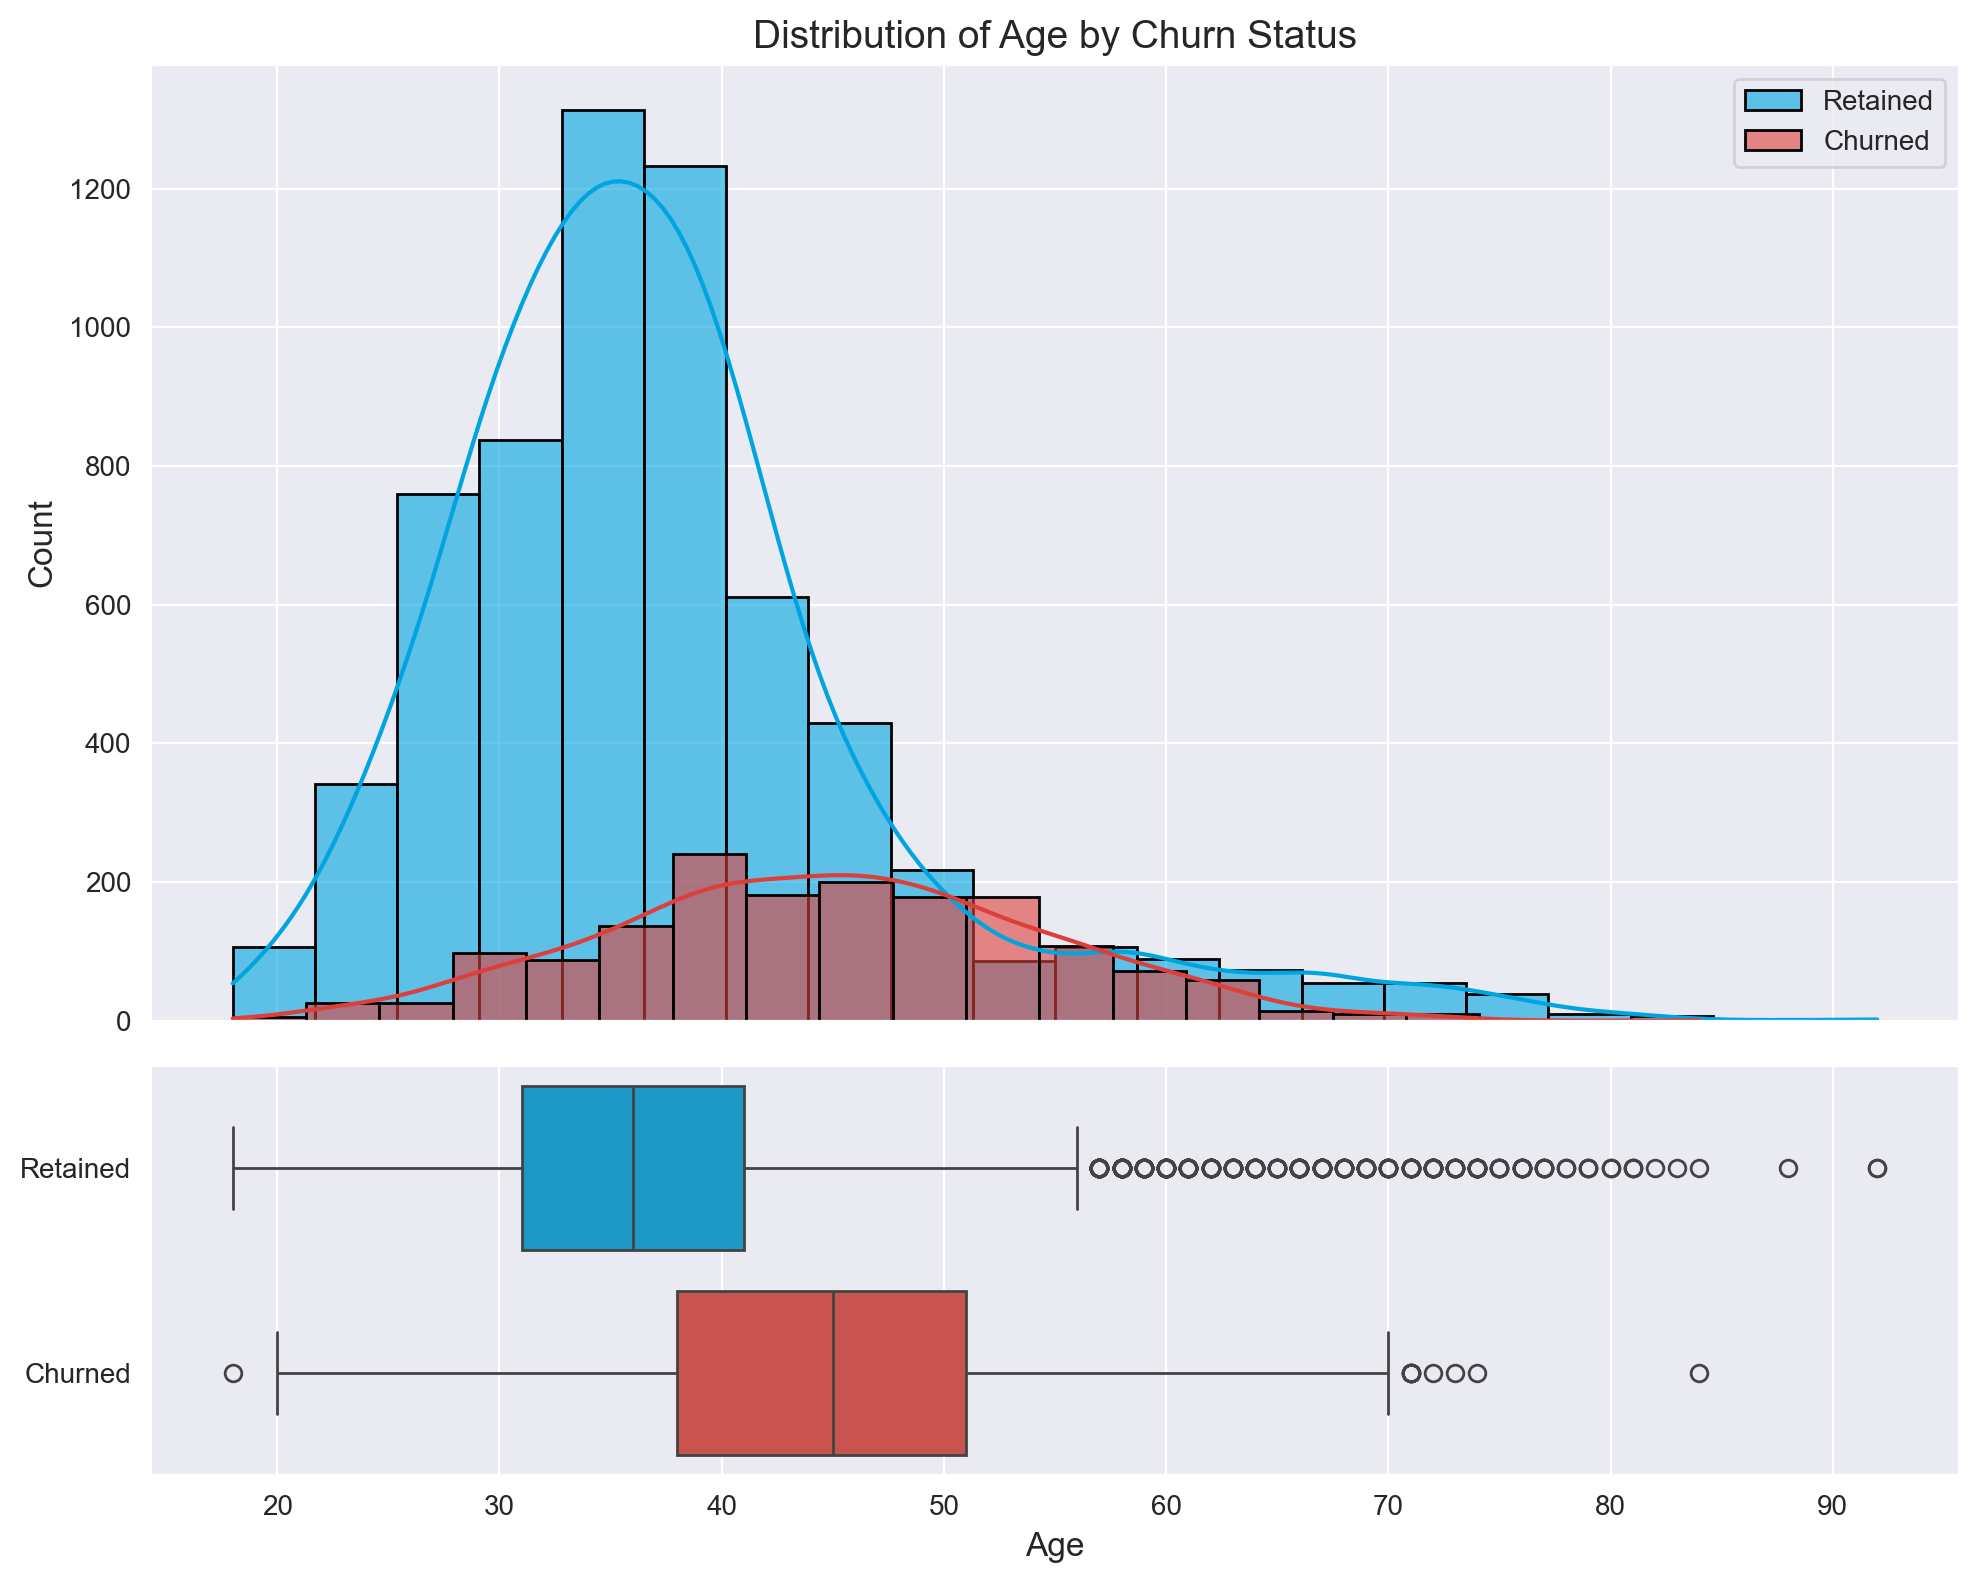


2. Balance Distribution by Churn Status:


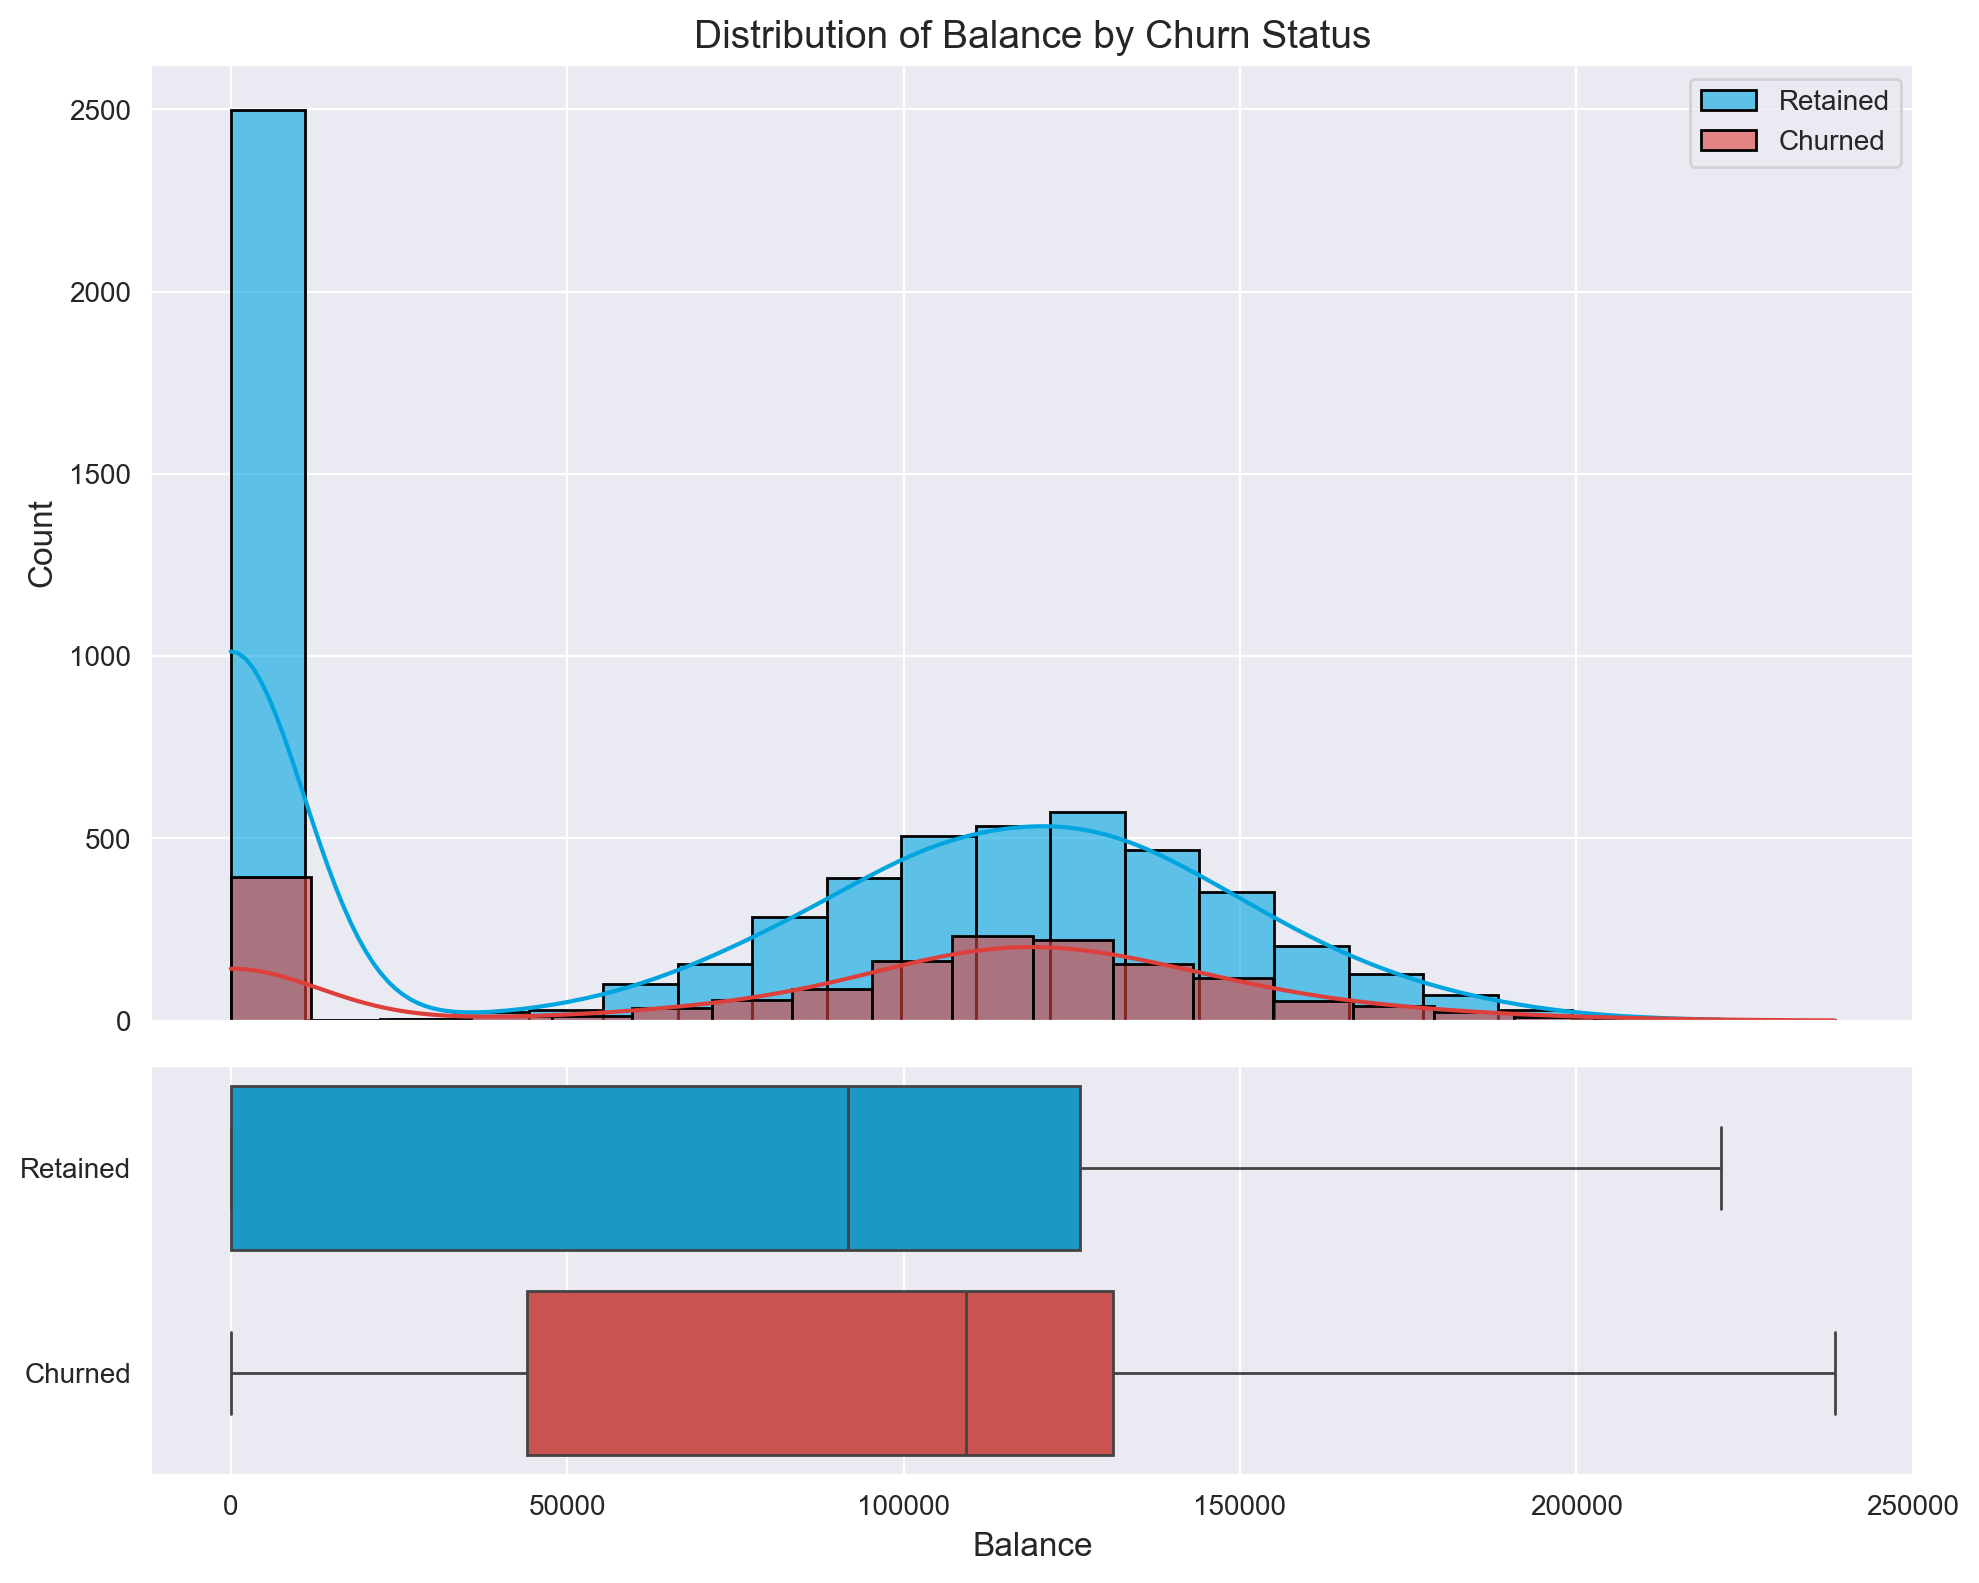


3. Categorical Features Analysis:

   a. Geography Distribution and Churn Rates:


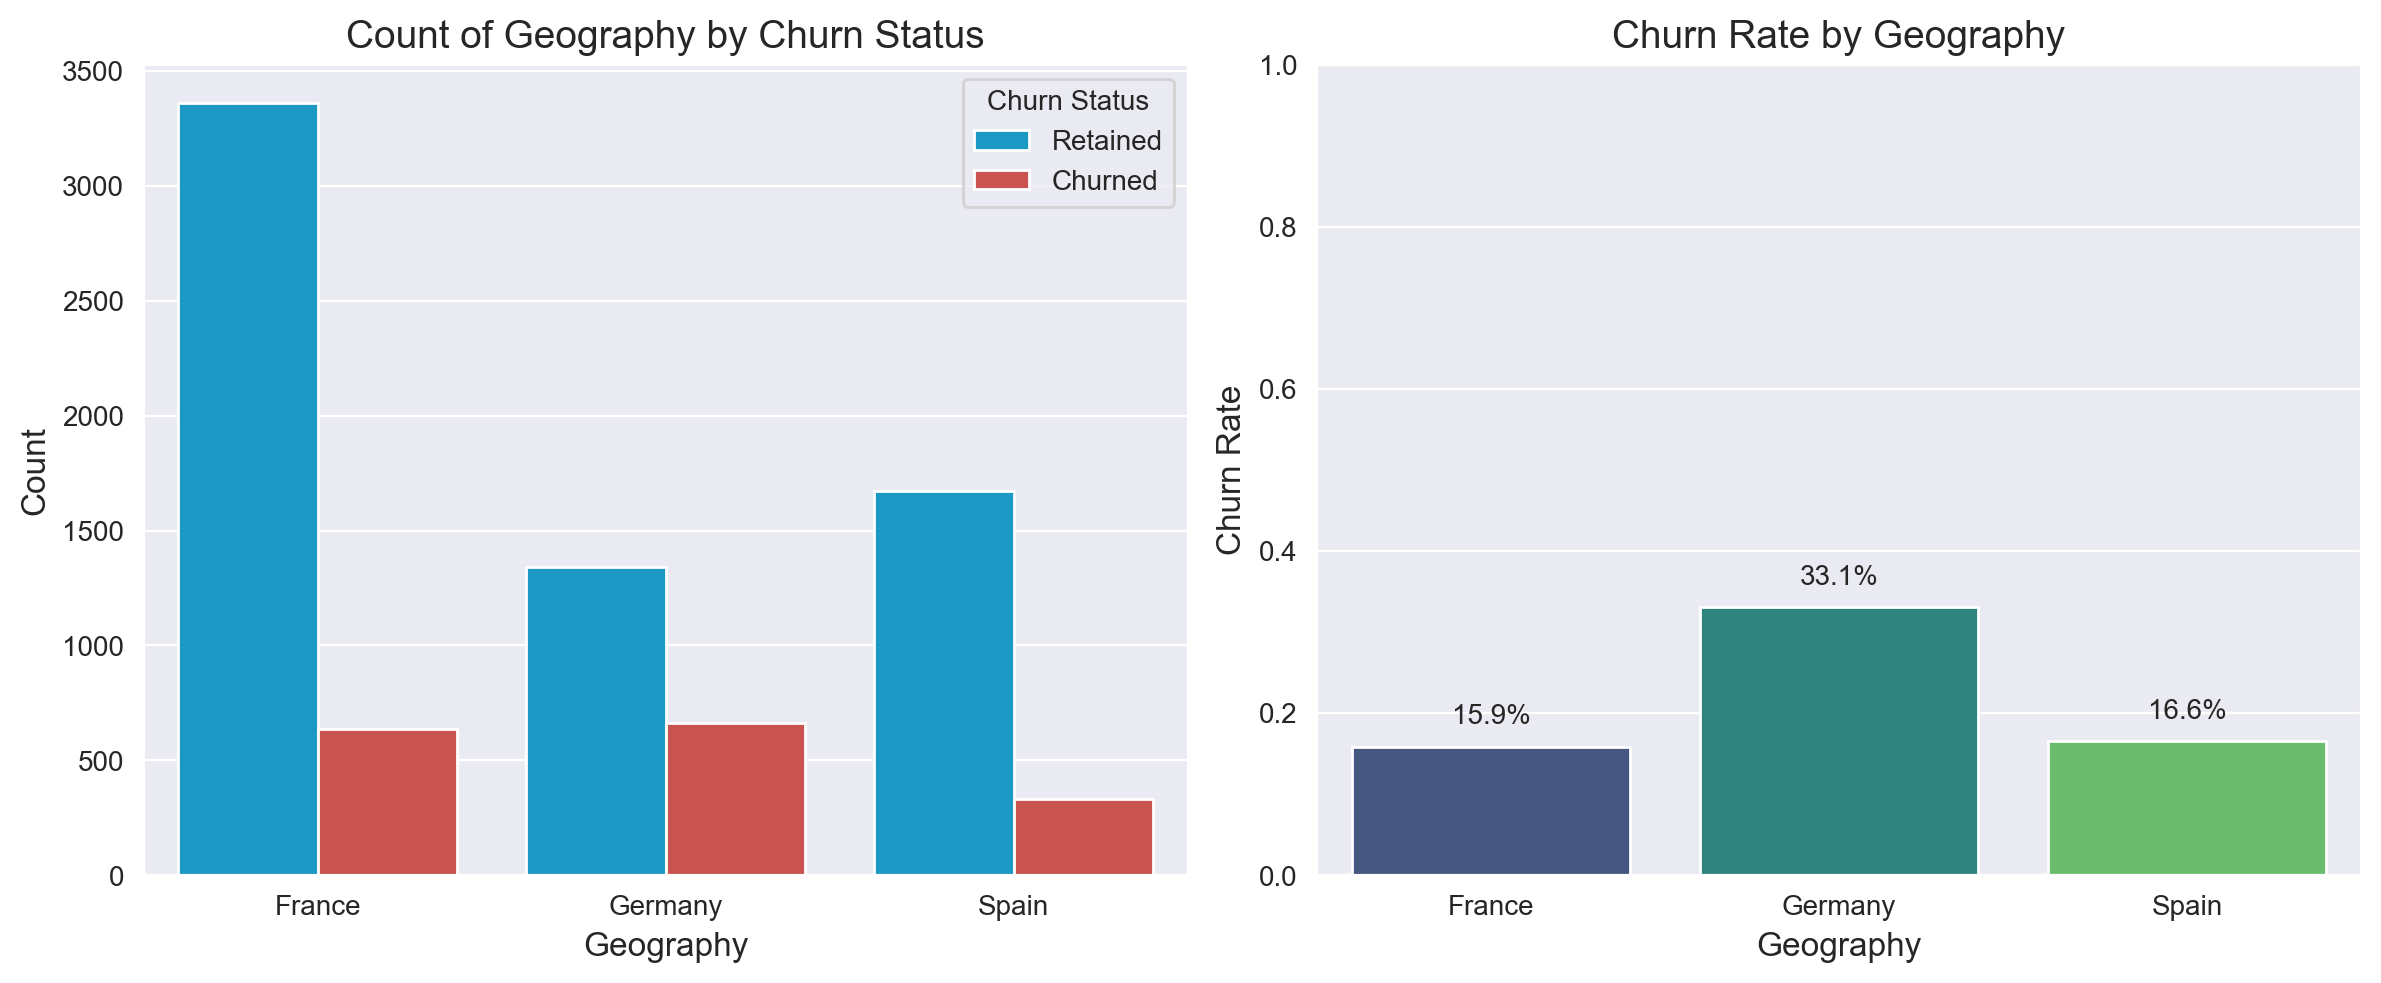


   b. Gender Distribution and Churn Rates:


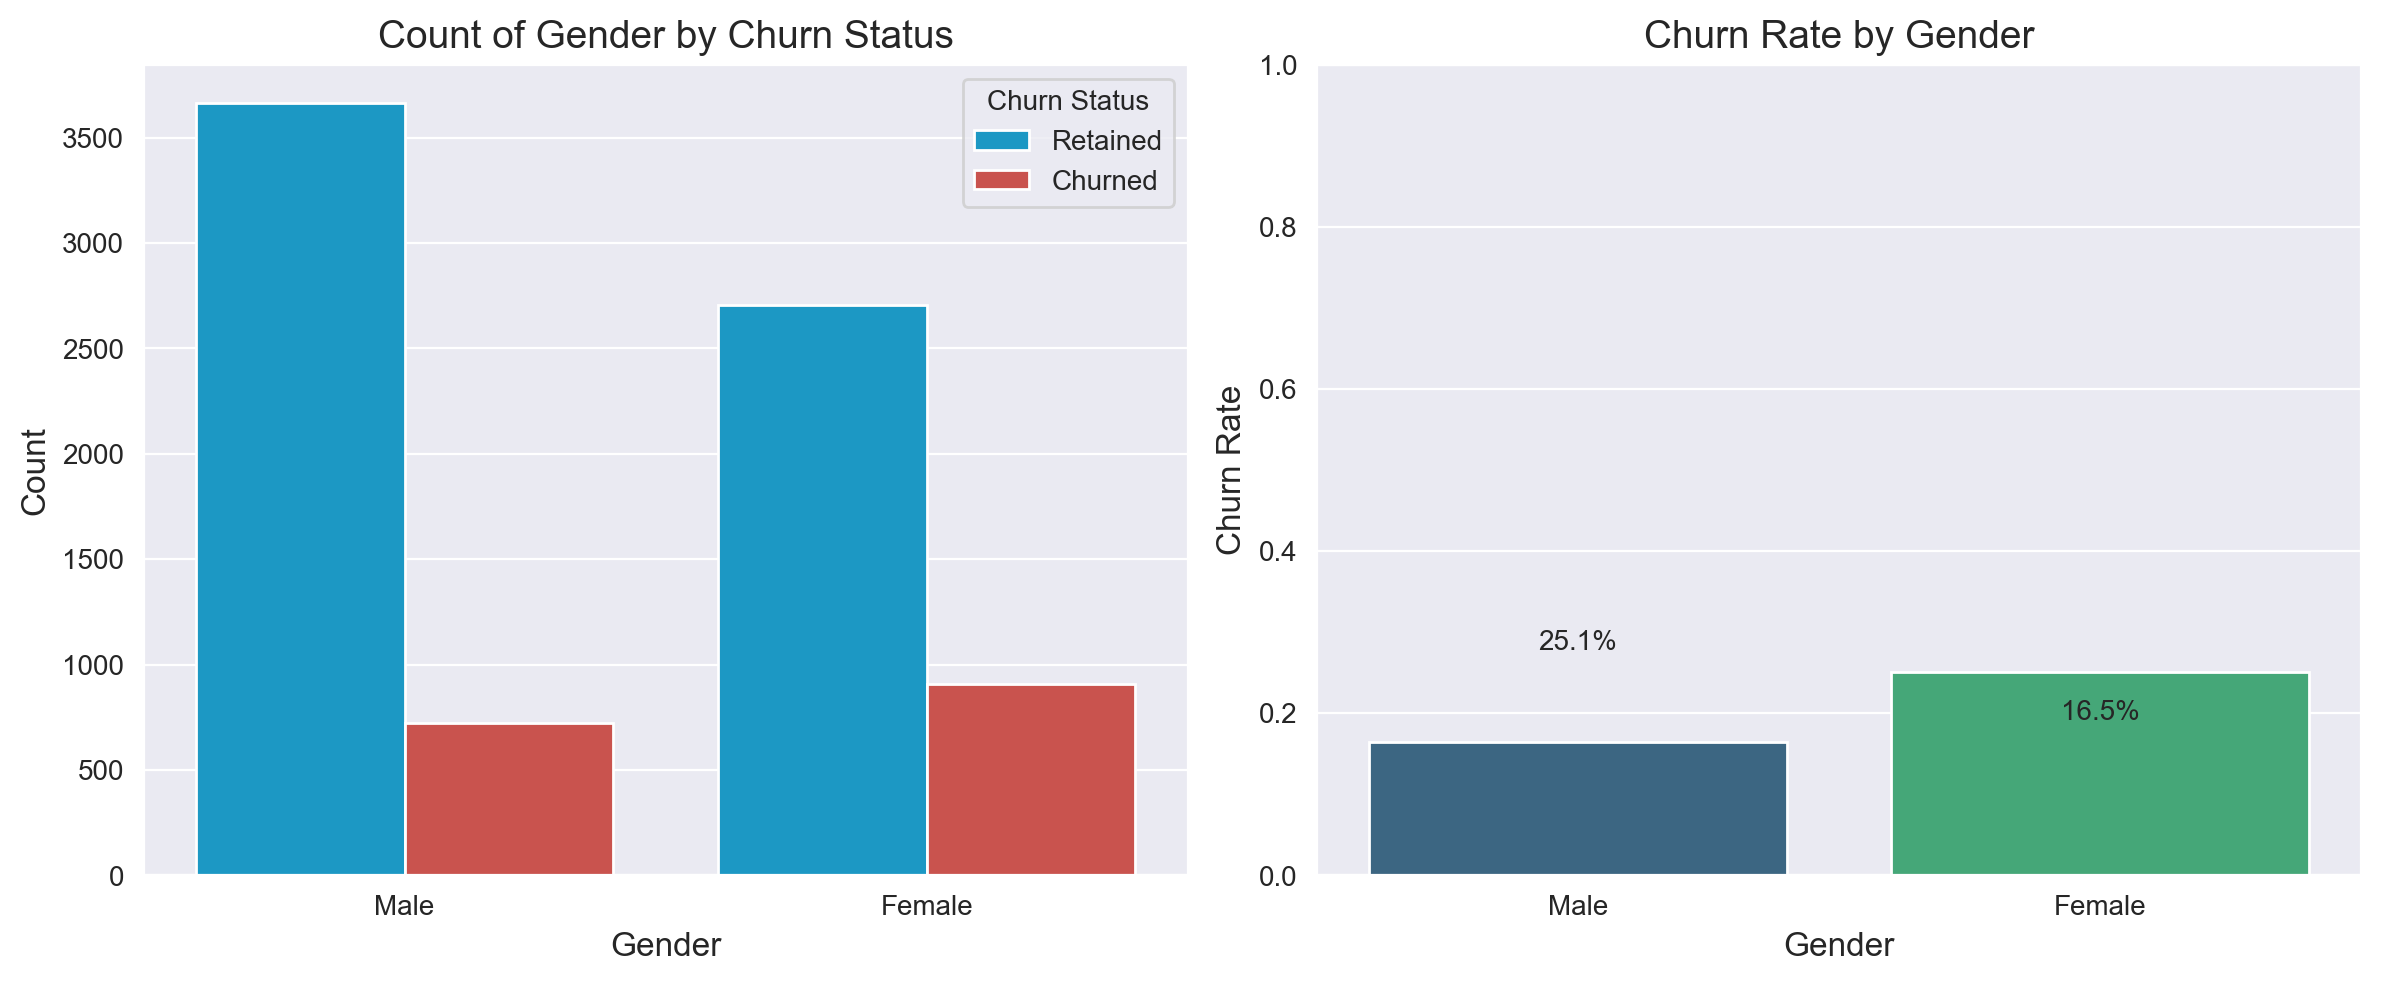


   c. IsActiveMember Distribution and Churn Rates:


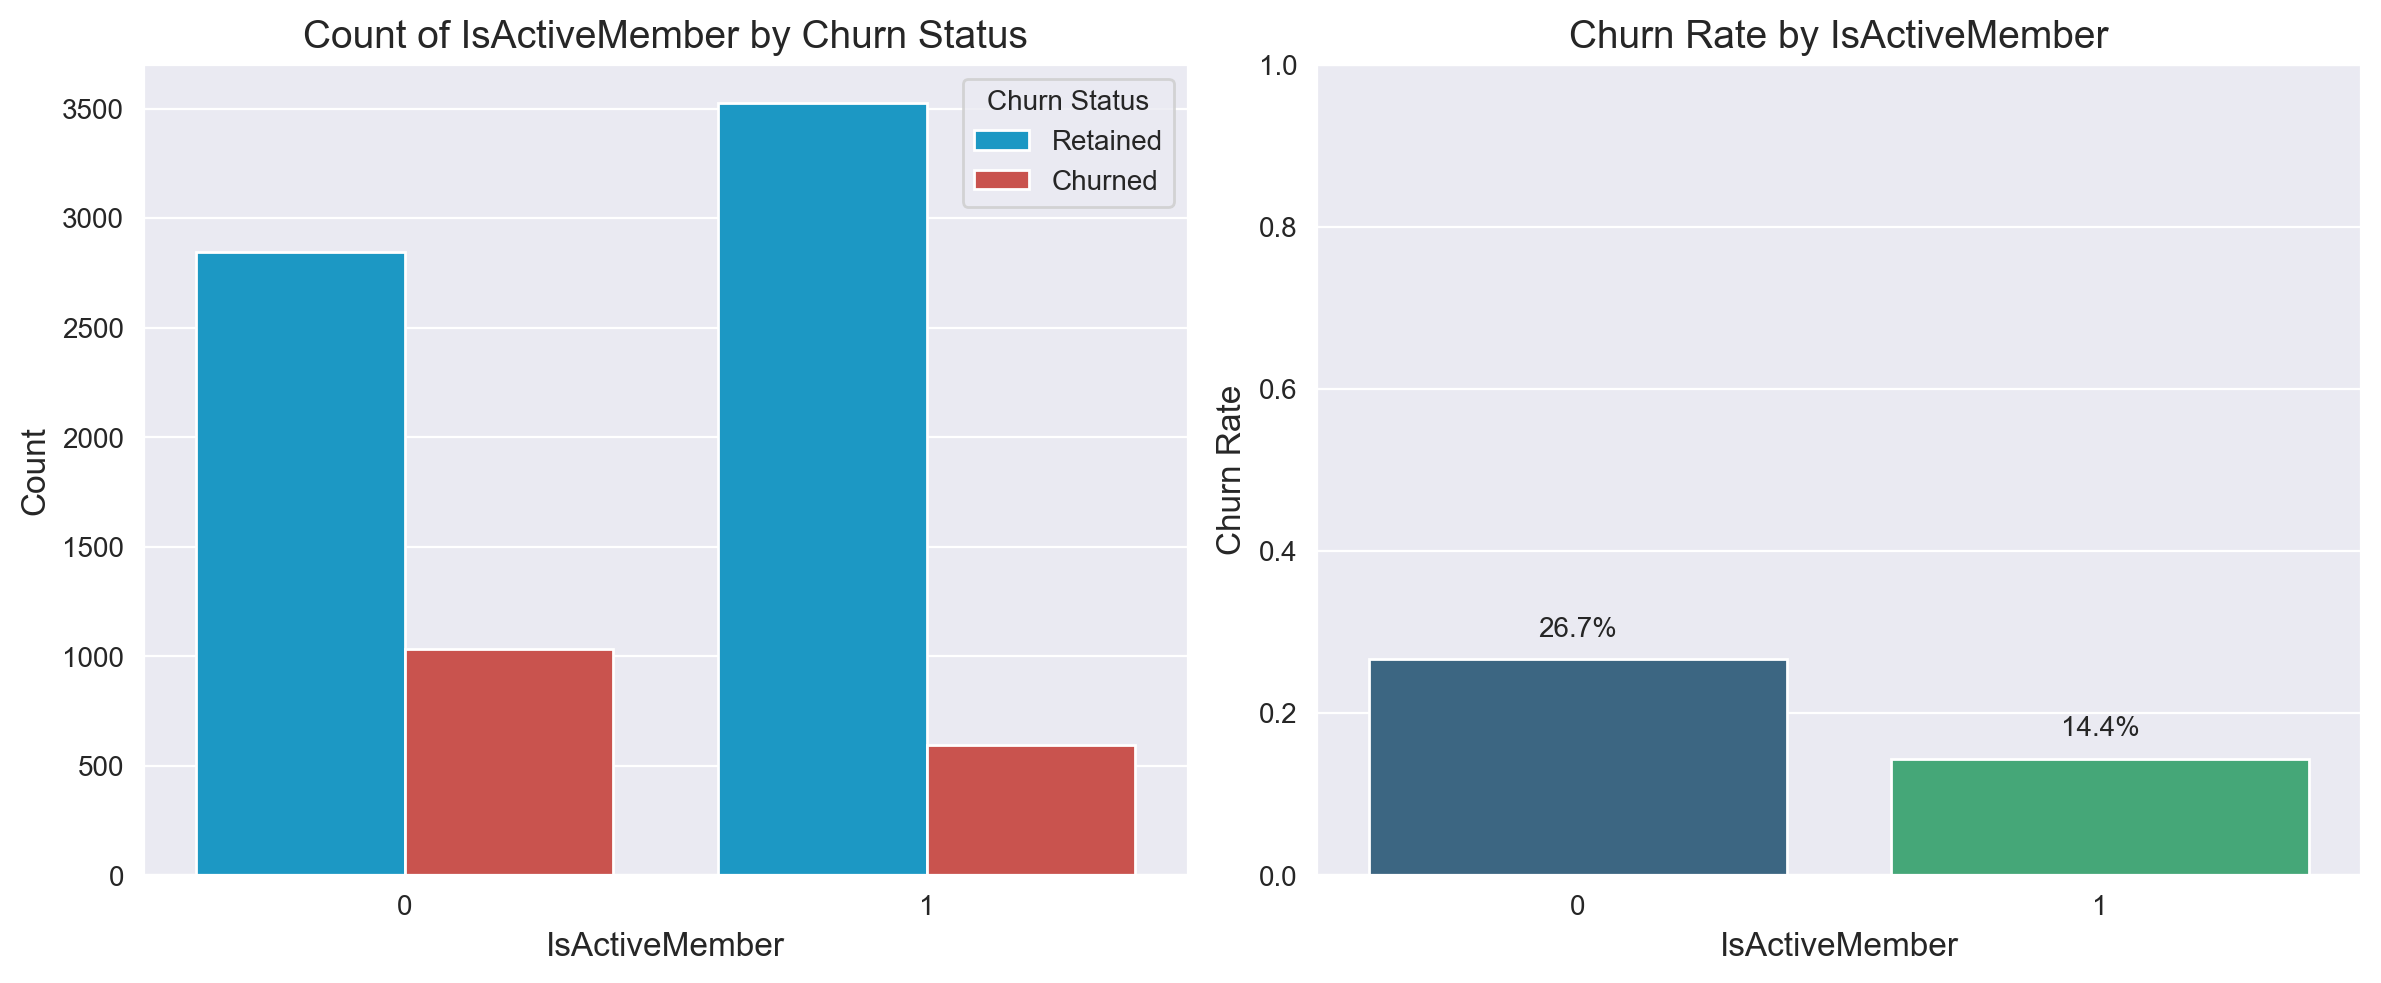

In [5]:
# Cell 5: Data visualization examples
print("DATA VISUALIZATION EXAMPLES")
print("=" * 50)

# Check if we have the necessary data
if 'Exited' in train_df.columns and 'df_churned' in locals() and 'df_retained' in locals():
    
    # Example 1: Visualize Age distribution
    print("\n1. Age Distribution by Churn Status:")
    if 'Age' in train_df.columns:
        plot_continuous('Age', train_df, df_churned, df_retained)
    else:
        print("   'Age' column not found in data")
    
    # Example 2: Visualize Balance distribution
    print("\n2. Balance Distribution by Churn Status:")
    if 'Balance' in train_df.columns:
        plot_continuous('Balance', train_df, df_churned, df_retained)
    else:
        print("   'Balance' column not found in data")
    
    # Example 3: Visualize categorical features
    print("\n3. Categorical Features Analysis:")
    
    # Check for Geography
    if 'Geography' in train_df.columns:
        print("\n   a. Geography Distribution and Churn Rates:")
        plot_categorical('Geography', train_df)
    else:
        print("\n   'Geography' column not found in data")
    
    # Check for Gender
    if 'Gender' in train_df.columns:
        print("\n   b. Gender Distribution and Churn Rates:")
        plot_categorical('Gender', train_df)
    else:
        print("\n   'Gender' column not found in data")
    
    # Check for IsActiveMember
    if 'IsActiveMember' in train_df.columns:
        print("\n   c. IsActiveMember Distribution and Churn Rates:")
        plot_categorical('IsActiveMember', train_df)
    else:
        print("\n   'IsActiveMember' column not found in data")
        
else:
    print("\nCannot visualize: Required data not available")
    print("Make sure 'Exited' column exists and train_df, df_churned, df_retained are defined")

print("\n" + "=" * 50)

In [6]:
# Cell 6: Data preparation for modeling
print("DATA PREPARATION FOR MODELING")
print("=" * 50)

# Check if Exited column exists
if 'Exited' not in df_clean.columns:
    print("Error: 'Exited' column not found in data.")
    print("Using the last column as target variable...")
    target_col = df_clean.columns[-1]
    df_clean = df_clean.rename(columns={target_col: 'Exited'})

# Separate features and target
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns to encode: {categorical_cols}")

# One-hot encode categorical variables
if categorical_cols:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"After encoding: {X_encoded.shape[1]} features")
else:
    X_encoded = X.copy()
    print("No categorical columns to encode")

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=random_state, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

if numerical_cols:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    print("✓ Numerical features scaled")
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    print("No numerical features to scale")

print("\n" + "=" * 50)

DATA PREPARATION FOR MODELING
Features shape: (10000, 10)
Target shape: (10000,)

Categorical columns to encode: ['Geography', 'Gender']
After encoding: 11 features

Train set: (8000, 11)
Test set: (2000, 11)
✓ Numerical features scaled



In [7]:
# Cell 7: Define model evaluation functions
def plot_learning_curve(estimator, X, y, ax, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'):
    """
    Plot the learning curves for an estimator.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, 
        scoring=scoring, random_state=random_state
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Fill between the standard deviation
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='dodgerblue')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorange')
    
    # Plot the mean scores
    ax.plot(train_sizes, train_scores_mean, 'o-', color='dodgerblue', label='Training Score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='darkorange', label='Cross-validation Score')
    
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.set_title(f'Learning Curve ({scoring})')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)

def evaluate_model(classifier, model_name, X_train, y_train, X_test, y_test):
    """
    Evaluate a model and return performance metrics.
    """
    # Train the model
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    
    # Calculate probabilities if available
    if hasattr(classifier, 'predict_proba'):
        y_proba_train = classifier.predict_proba(X_train)[:, 1]
        y_proba_test = classifier.predict_proba(X_test)[:, 1]
    else:
        y_proba_train = None
        y_proba_test = None
    
    # Calculate metrics
    metrics_train = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train),
        'recall': recall_score(y_train, y_pred_train),
        'roc_auc': roc_auc_score(y_train, y_proba_train) if y_proba_train is not None else None
    }
    
    metrics_test = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'roc_auc': roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None
    }
    
    # Create confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    return metrics_train, metrics_test, cm_test, classifier

def plot_model_performance(model_name, metrics_train, metrics_test, cm_test, classifier=None, X_train=None, y_train=None):
    """
    Plot model performance visualizations.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Confusion Matrix
    plot_confusion_matrix(cm_test, axes[0], title=f'{model_name} - Confusion Matrix')
    
    # 2. Learning Curve (if classifier and data provided)
    if classifier is not None and X_train is not None and y_train is not None:
        plot_learning_curve(classifier, X_train, y_train, axes[1])
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Learning Curve\nNot Available', 
                    ha='center', va='center', fontsize=12)
    
    # 3. Metrics Comparison
    metrics_df = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'Accuracy': [metrics_train['accuracy'], metrics_test['accuracy']],
        'Precision': [metrics_train['precision'], metrics_test['precision']],
        'Recall': [metrics_train['recall'], metrics_test['recall']]
    })
    
    if metrics_train['roc_auc'] is not None and metrics_test['roc_auc'] is not None:
        metrics_df['ROC-AUC'] = [metrics_train['roc_auc'], metrics_test['roc_auc']]
    
    x = np.arange(len(metrics_df))
    width = 0.2
    
    # Plot metrics
    for i, metric in enumerate(['Accuracy', 'Precision', 'Recall']):
        axes[2].bar(x + i*width - width, metrics_df[metric], width, label=metric)
    
    axes[2].set_xlabel('Dataset')
    axes[2].set_ylabel('Score')
    axes[2].set_title(f'{model_name} - Performance Metrics')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(metrics_df['Dataset'])
    axes[2].legend()
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print("-" * 30)
    print("Training Set:")
    for metric, value in metrics_train.items():
        if value is not None:
            print(f"  {metric}: {value:.4f}")
    
    print("\nTest Set:")
    for metric, value in metrics_test.items():
        if value is not None:
            print(f"  {metric}: {value:.4f}")

print('✔️ Model evaluation functions defined!')

✔️ Model evaluation functions defined!


TRAINING BASELINE MODELS

------------------------------
Training Logistic Regression...


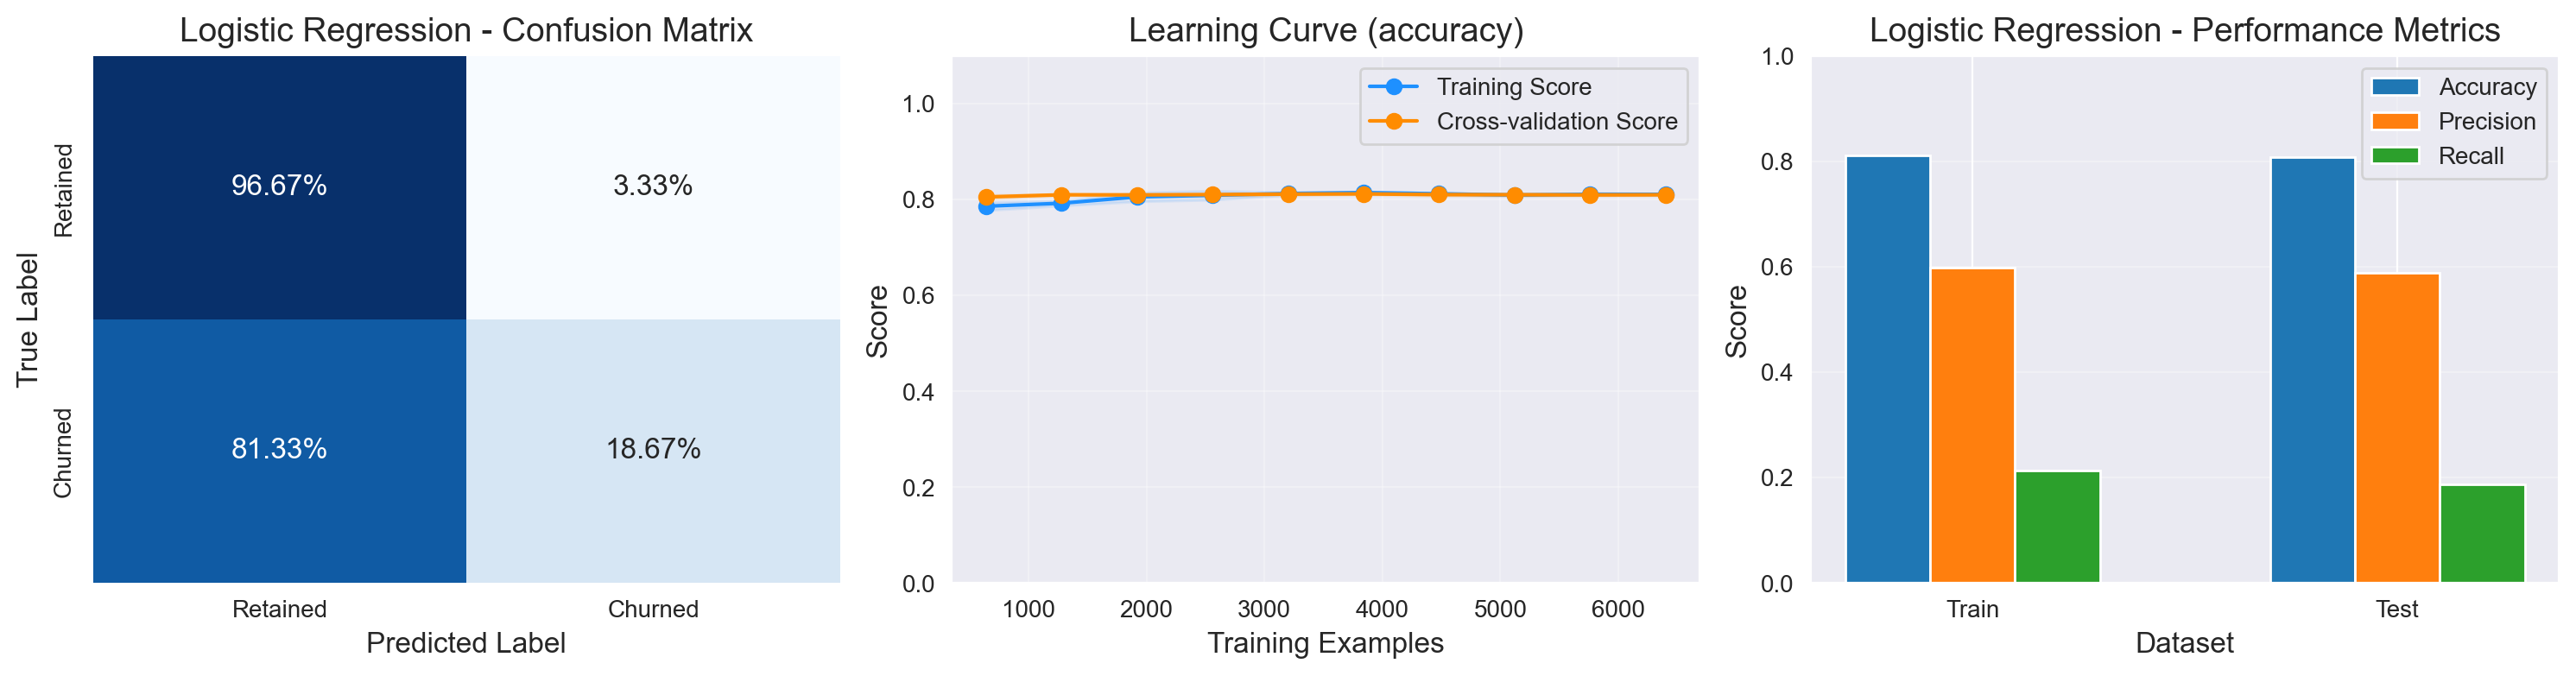


Logistic Regression Performance:
------------------------------
Training Set:
  accuracy: 0.8106
  precision: 0.5986
  recall: 0.2141
  roc_auc: 0.7654

Test Set:
  accuracy: 0.8080
  precision: 0.5891
  recall: 0.1867
  roc_auc: 0.7748

------------------------------
Training Random Forest...


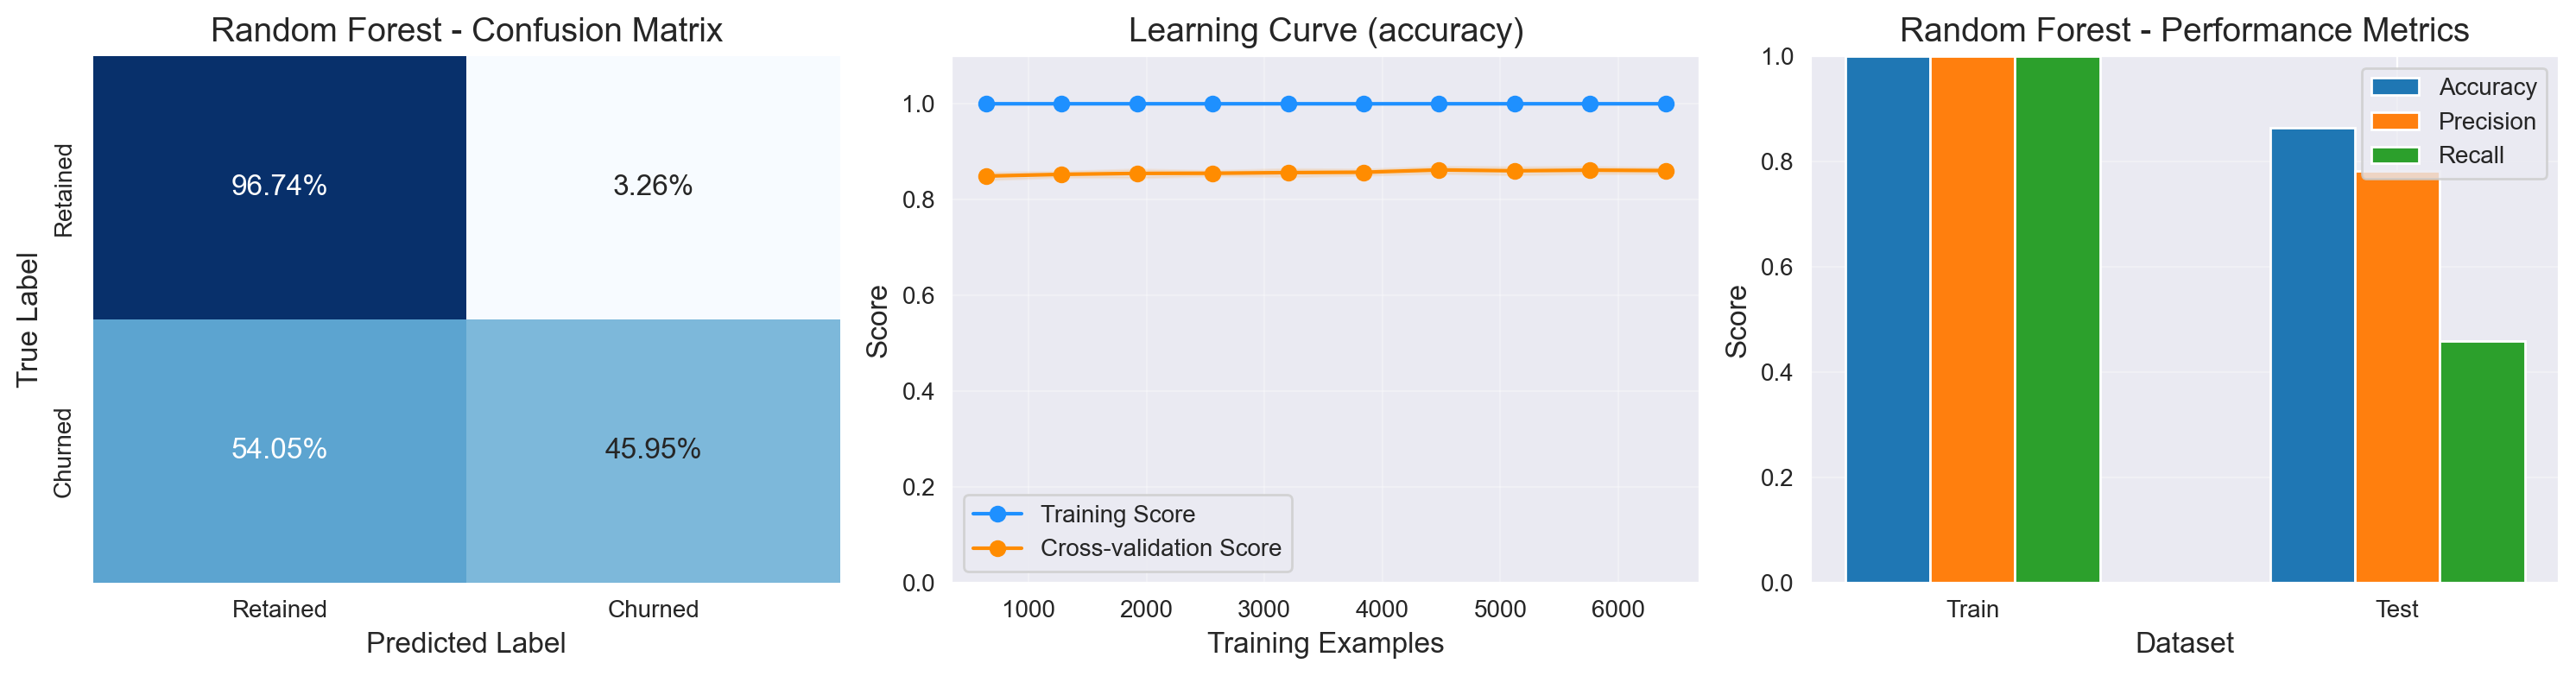


Random Forest Performance:
------------------------------
Training Set:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  roc_auc: 1.0000

Test Set:
  accuracy: 0.8640
  precision: 0.7824
  recall: 0.4595
  roc_auc: 0.8522

------------------------------
Training Gradient Boosting...


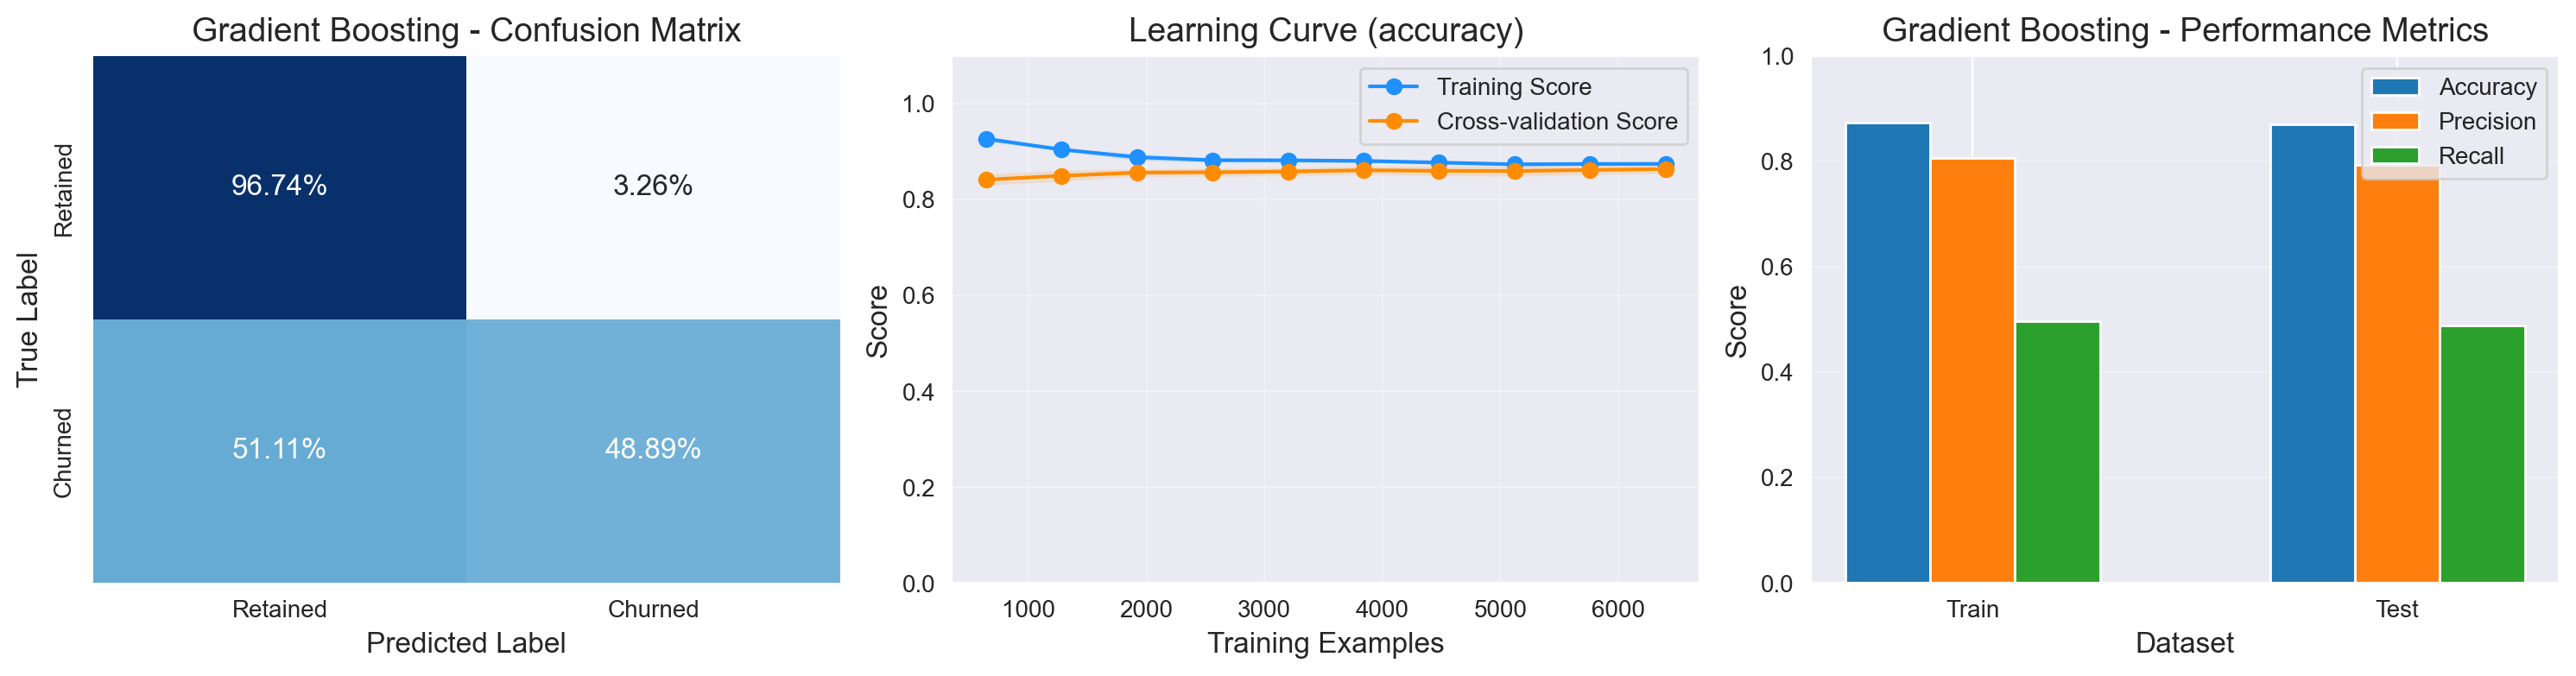


Gradient Boosting Performance:
------------------------------
Training Set:
  accuracy: 0.8730
  precision: 0.8058
  recall: 0.4963
  roc_auc: 0.8893

Test Set:
  accuracy: 0.8700
  precision: 0.7928
  recall: 0.4889
  roc_auc: 0.8708

------------------------------
Training AdaBoost...


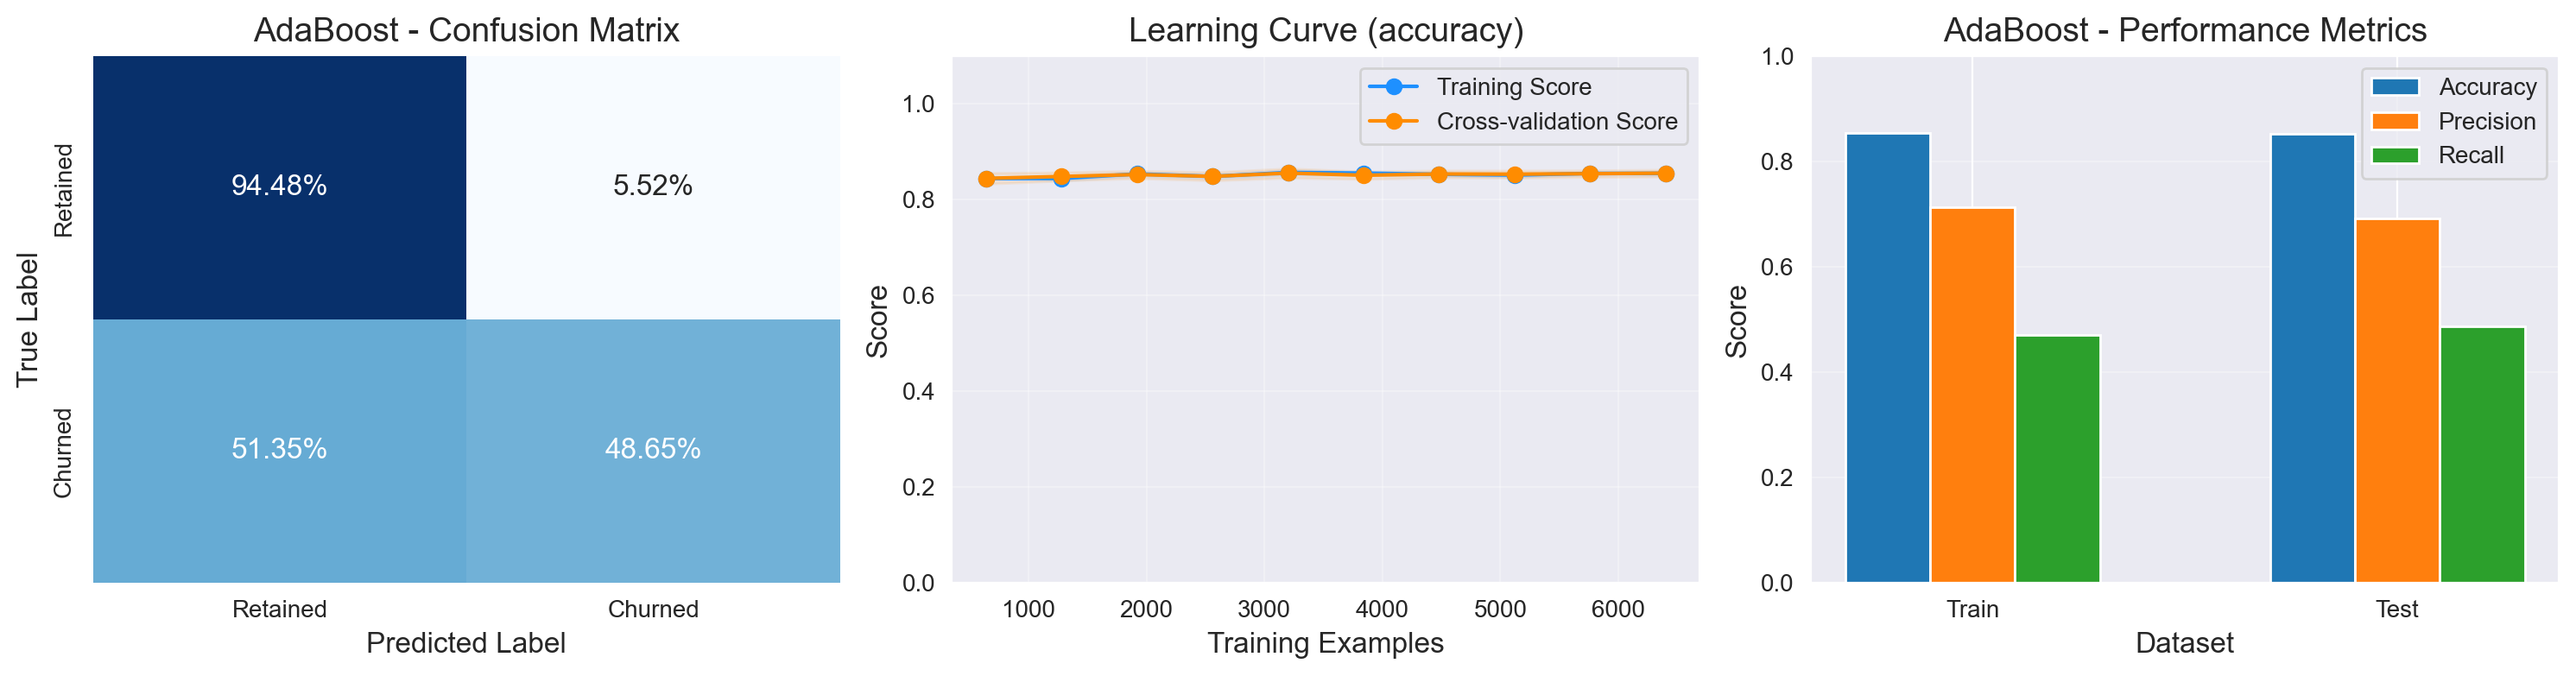


AdaBoost Performance:
------------------------------
Training Set:
  accuracy: 0.8534
  precision: 0.7122
  recall: 0.4706
  roc_auc: 0.8475

Test Set:
  accuracy: 0.8515
  precision: 0.6923
  recall: 0.4865
  roc_auc: 0.8491

------------------------------
Training SVM...


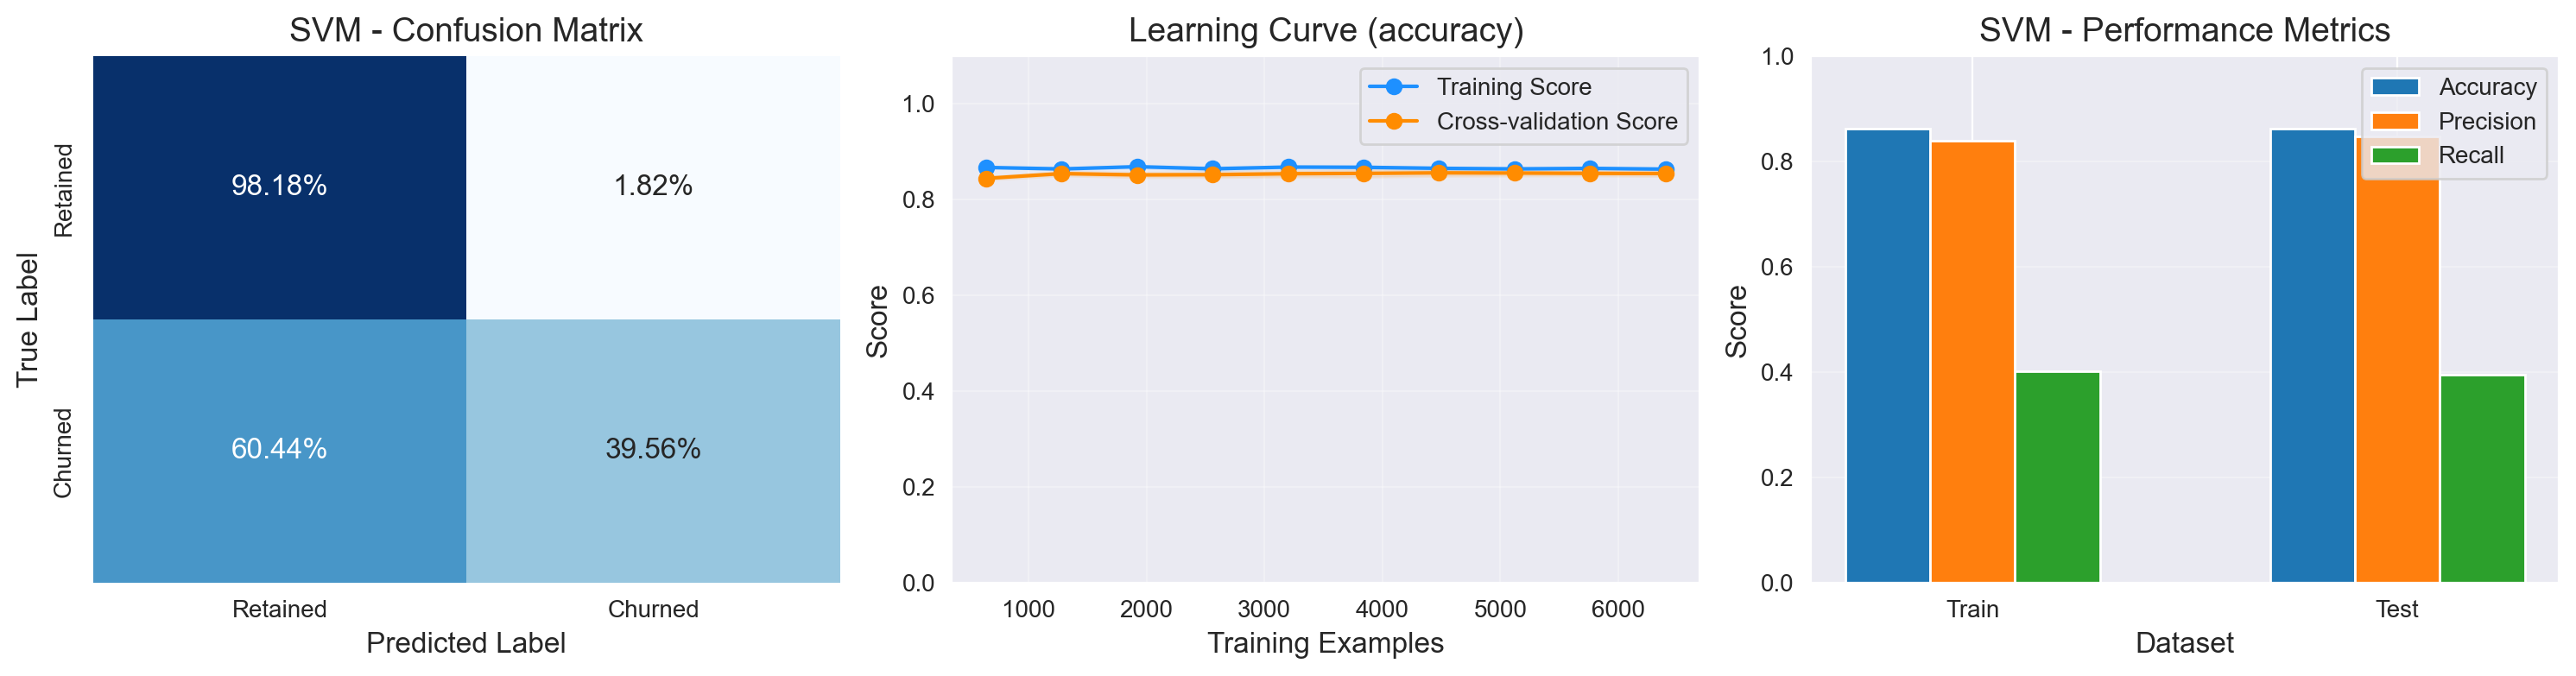


SVM Performance:
------------------------------
Training Set:
  accuracy: 0.8625
  precision: 0.8389
  recall: 0.4025
  roc_auc: 0.8719

Test Set:
  accuracy: 0.8625
  precision: 0.8474
  recall: 0.3956
  roc_auc: 0.8231



In [8]:
# Cell 8: Train and evaluate baseline models
print("TRAINING BASELINE MODELS")
print("=" * 50)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=random_state, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state, n_estimators=100),
    'AdaBoost': AdaBoostClassifier(random_state=random_state, n_estimators=100),
    'SVM': SVC(probability=True, random_state=random_state)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'-'*30}")
    print(f"Training {name}...")
    
    # Evaluate model
    metrics_train, metrics_test, cm_test, trained_model = evaluate_model(
        model, name, X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Store results
    results[name] = {
        'metrics_train': metrics_train,
        'metrics_test': metrics_test,
        'cm_test': cm_test,
        'model': trained_model
    }
    
    # Plot performance
    plot_model_performance(name, metrics_train, metrics_test, cm_test, 
                          trained_model, X_train_scaled, y_train)

print("\n" + "=" * 50)

HYPERPARAMETER TUNING EXAMPLE - RANDOM FOREST
Performing Grid Search with 81 parameter combinations...
This may take a few minutes...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

✓ Grid Search Complete!
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Best CV Score (ROC-AUC): 0.8628


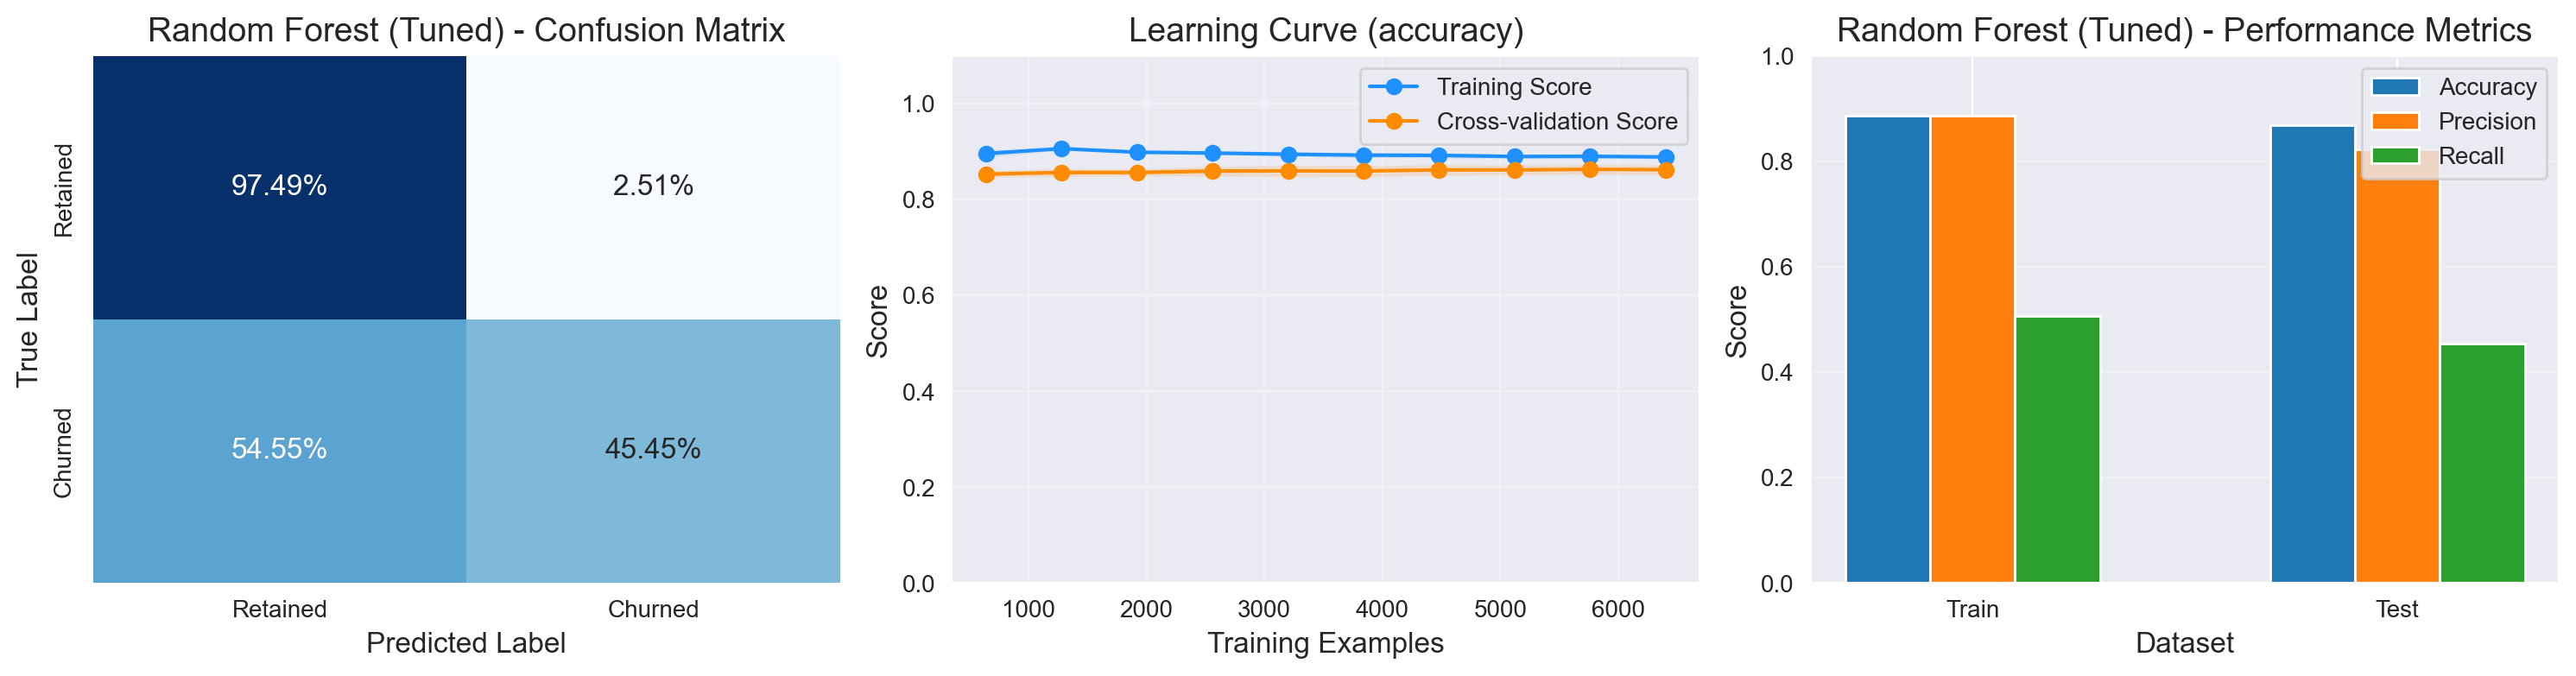


Random Forest (Tuned) Performance:
------------------------------
Training Set:
  accuracy: 0.8862
  precision: 0.8863
  recall: 0.5067
  roc_auc: 0.9384

Test Set:
  accuracy: 0.8690
  precision: 0.8222
  recall: 0.4545
  roc_auc: 0.8641



In [9]:
# Cell 9: Hyperparameter tuning example
print("HYPERPARAMETER TUNING EXAMPLE - RANDOM FOREST")
print("=" * 50)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"Performing Grid Search with {3*3*3*3} parameter combinations...")
print("This may take a few minutes...")

# Create and train grid search
rf = RandomForestClassifier(random_state=random_state)
grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='roc_auc', 
    n_jobs=-1, verbose=1, refit=True
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✓ Grid Search Complete!")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score (ROC-AUC): {grid_search.best_score_:.4f}")

# Evaluate the best model
best_rf = grid_search.best_estimator_
metrics_train, metrics_test, cm_test, _ = evaluate_model(
    best_rf, "Random Forest (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test
)

# Store results
results['Random Forest (Tuned)'] = {
    'metrics_train': metrics_train,
    'metrics_test': metrics_test,
    'cm_test': cm_test,
    'model': best_rf
}

# Plot performance
plot_model_performance("Random Forest (Tuned)", metrics_train, metrics_test, cm_test, 
                      best_rf, X_train_scaled, y_train)

print("\n" + "=" * 50)

MODEL COMPARISON

Model Performance Comparison (Test Set):
--------------------------------------------------


,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic Regression,0.8080,0.5891,0.1867,0.7748
1,Random Forest,0.8640,0.7824,0.4595,0.8522
2,Gradient Boosting,0.8700,0.7928,0.4889,0.8708
3,AdaBoost,0.8515,0.6923,0.4865,0.8491
4,SVM,0.8625,0.8474,0.3956,0.8231
5,Random Forest (Tuned),0.8690,0.8222,0.4545,0.8641


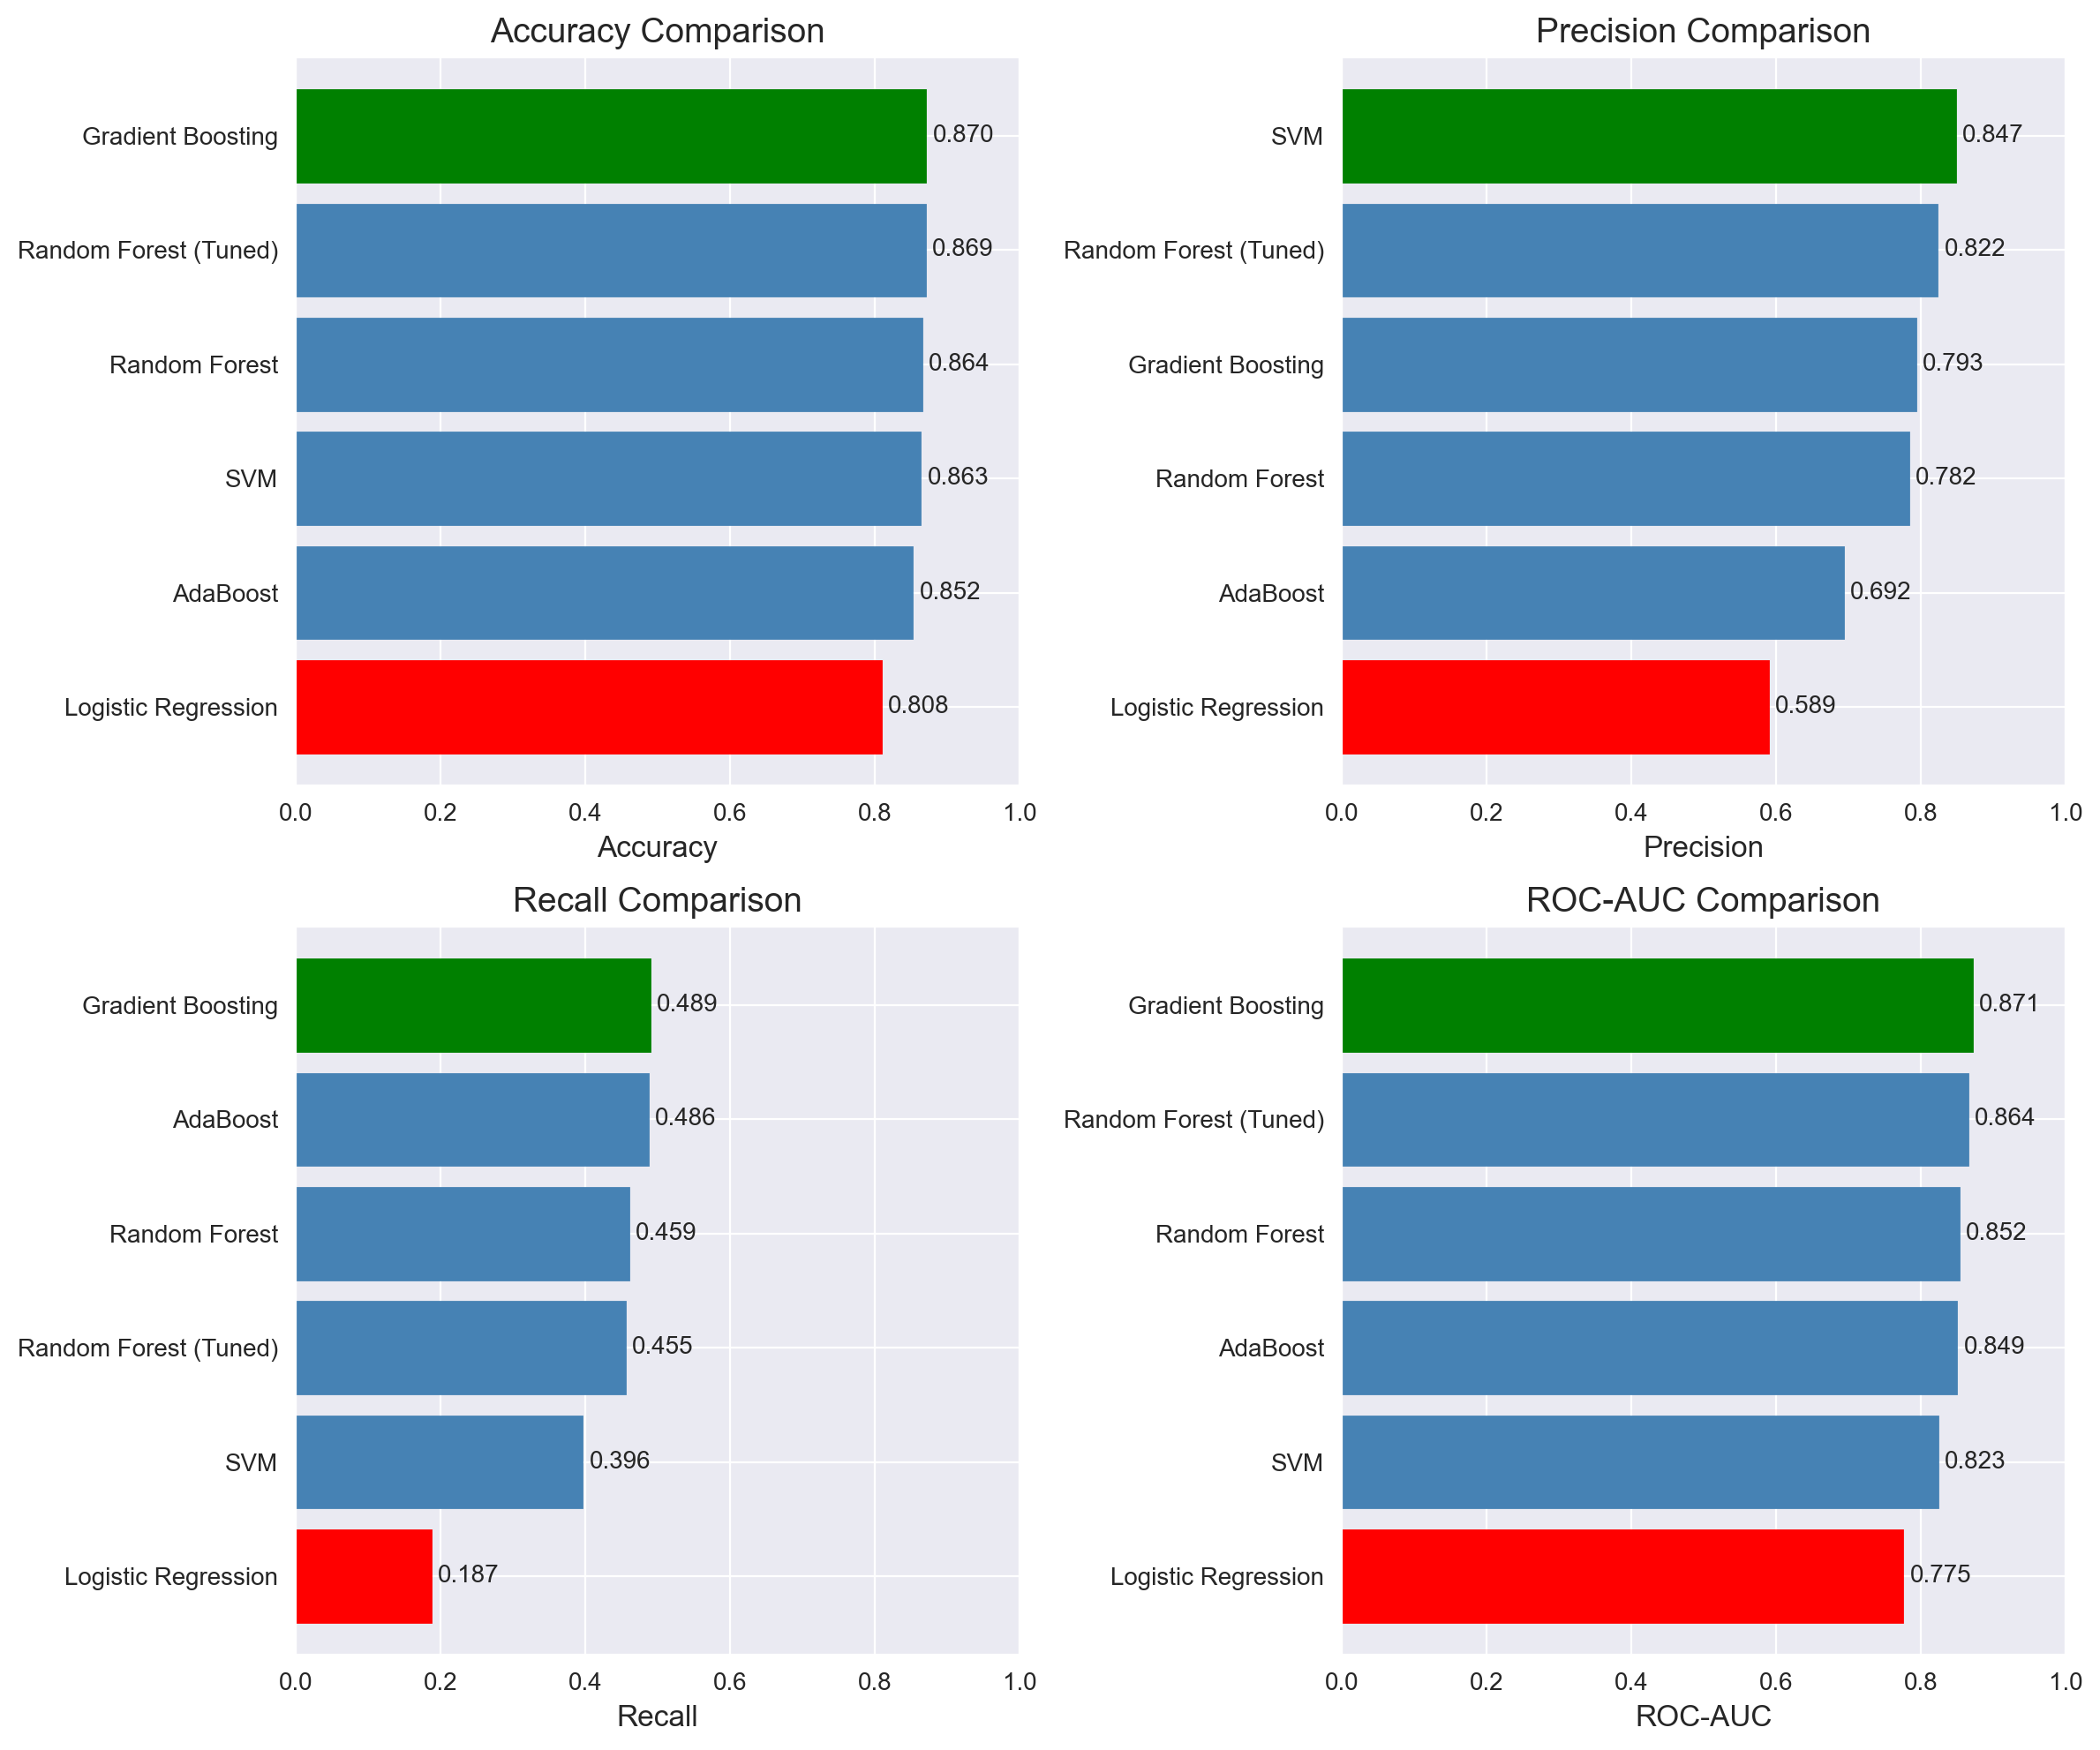

In [10]:
# Cell 10: Model comparison visualization
print("MODEL COMPARISON")
print("=" * 50)

# Create comparison DataFrame
comparison_data = []
for model_name, result in results.items():
    metrics_test = result['metrics_test']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics_test['accuracy'],
        'Precision': metrics_test['precision'],
        'Recall': metrics_test['recall'],
        'ROC-AUC': metrics_test['roc_auc'] if metrics_test['roc_auc'] is not None else np.nan
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nModel Performance Comparison (Test Set):")
print("-" * 50)
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'ROC-AUC': '{:.4f}'
}).highlight_max(color='lightgreen').highlight_min(color='lightcoral'))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric value
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    # Create horizontal bar chart
    y_pos = np.arange(len(sorted_df))
    bars = ax.barh(y_pos, sorted_df[metric])
    
    # Color bars
    for i, bar in enumerate(bars):
        if sorted_df[metric].iloc[i] == sorted_df[metric].max():
            bar.set_color('green')
        elif sorted_df[metric].iloc[i] == sorted_df[metric].min():
            bar.set_color('red')
        else:
            bar.set_color('steelblue')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df['Model'])
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        if not np.isnan(v):
            ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)

MODEL COMPARISON

Model Performance Comparison (Test Set):
--------------------------------------------------


,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic Regression,0.8080,0.5891,0.1867,0.7748
1,Random Forest,0.8640,0.7824,0.4595,0.8522
2,Gradient Boosting,0.8700,0.7928,0.4889,0.8708
3,AdaBoost,0.8515,0.6923,0.4865,0.8491
4,SVM,0.8625,0.8474,0.3956,0.8231
5,Random Forest (Tuned),0.8690,0.8222,0.4545,0.8641


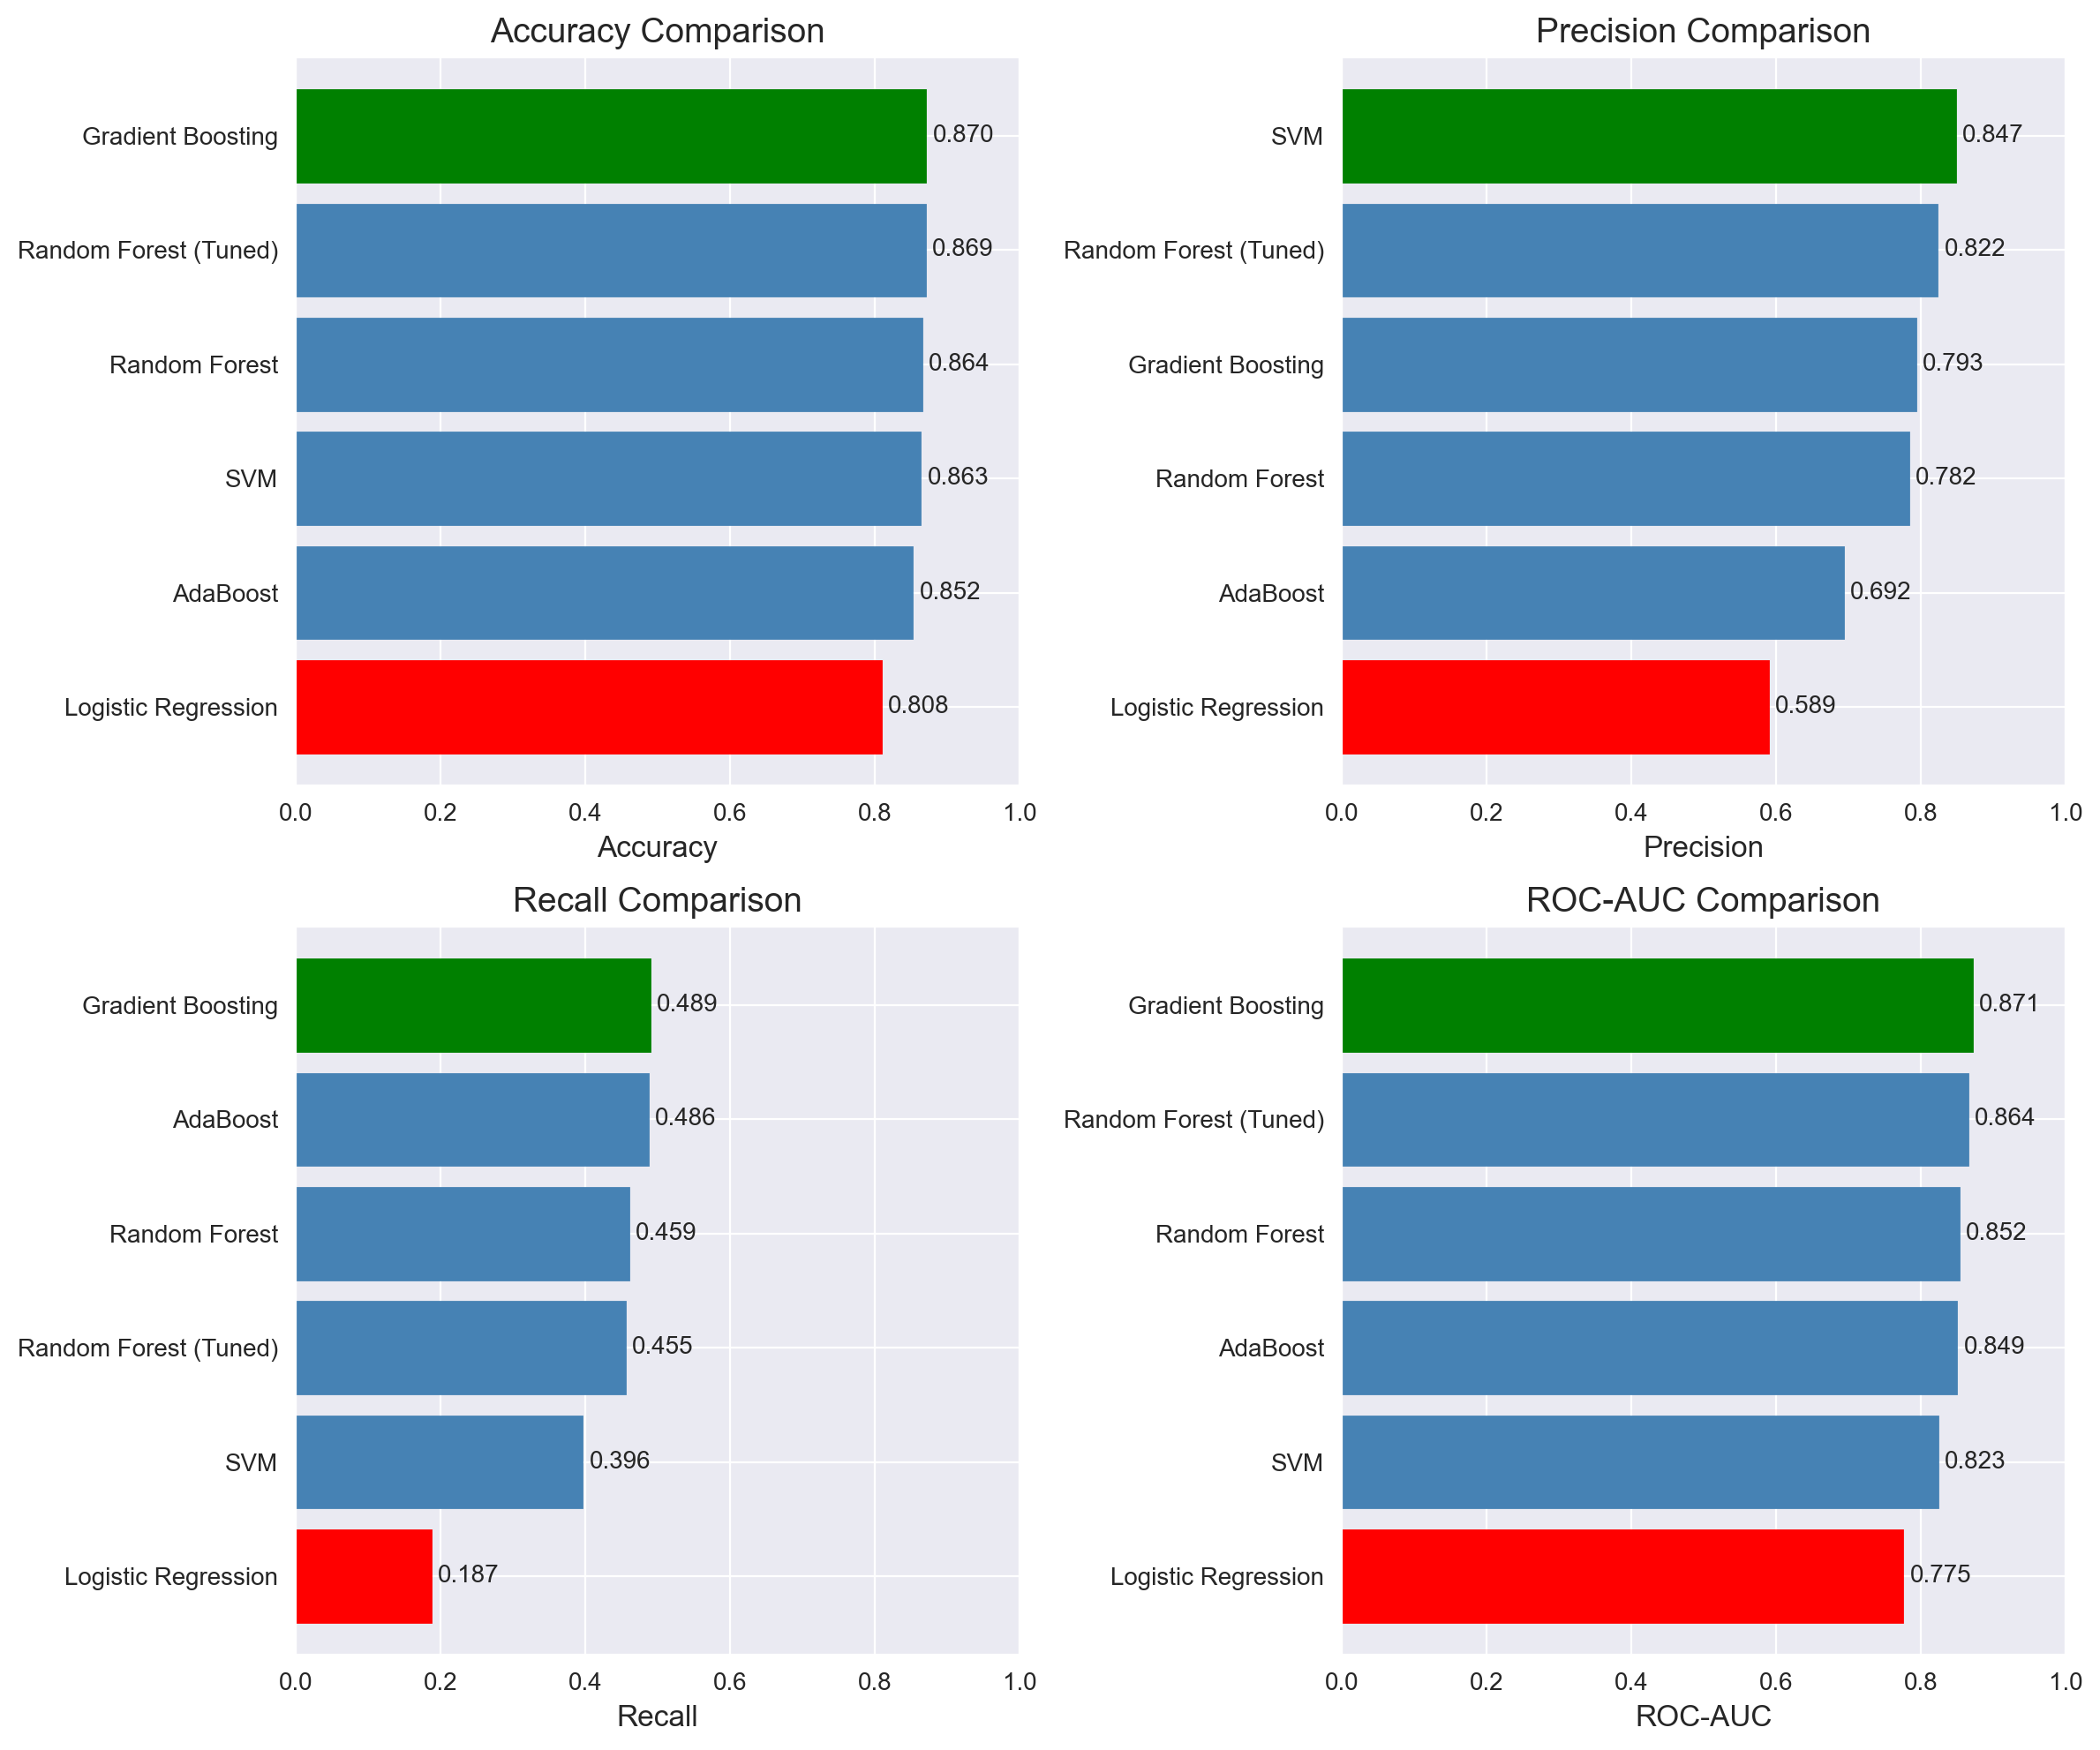

In [11]:
# Cell 10: Model comparison visualization
print("MODEL COMPARISON")
print("=" * 50)

# Create comparison DataFrame
comparison_data = []
for model_name, result in results.items():
    metrics_test = result['metrics_test']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics_test['accuracy'],
        'Precision': metrics_test['precision'],
        'Recall': metrics_test['recall'],
        'ROC-AUC': metrics_test['roc_auc'] if metrics_test['roc_auc'] is not None else np.nan
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nModel Performance Comparison (Test Set):")
print("-" * 50)
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'ROC-AUC': '{:.4f}'
}).highlight_max(color='lightgreen').highlight_min(color='lightcoral'))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric value
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    # Create horizontal bar chart
    y_pos = np.arange(len(sorted_df))
    bars = ax.barh(y_pos, sorted_df[metric])
    
    # Color bars
    for i, bar in enumerate(bars):
        if sorted_df[metric].iloc[i] == sorted_df[metric].max():
            bar.set_color('green')
        elif sorted_df[metric].iloc[i] == sorted_df[metric].min():
            bar.set_color('red')
        else:
            bar.set_color('steelblue')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df['Model'])
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        if not np.isnan(v):
            ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)

FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance for: Gradient Boosting

Top 10 most important features:


,Feature,Importance
1,Age,0.3881
4,NumOfProducts,0.2999
6,IsActiveMember,0.1139
3,Balance,0.0892
8,Geography_Germany,0.0556
0,CreditScore,0.0187
7,EstimatedSalary,0.0165
10,Gender_Male,0.0132
2,Tenure,0.0038
5,HasCrCard,0.0007


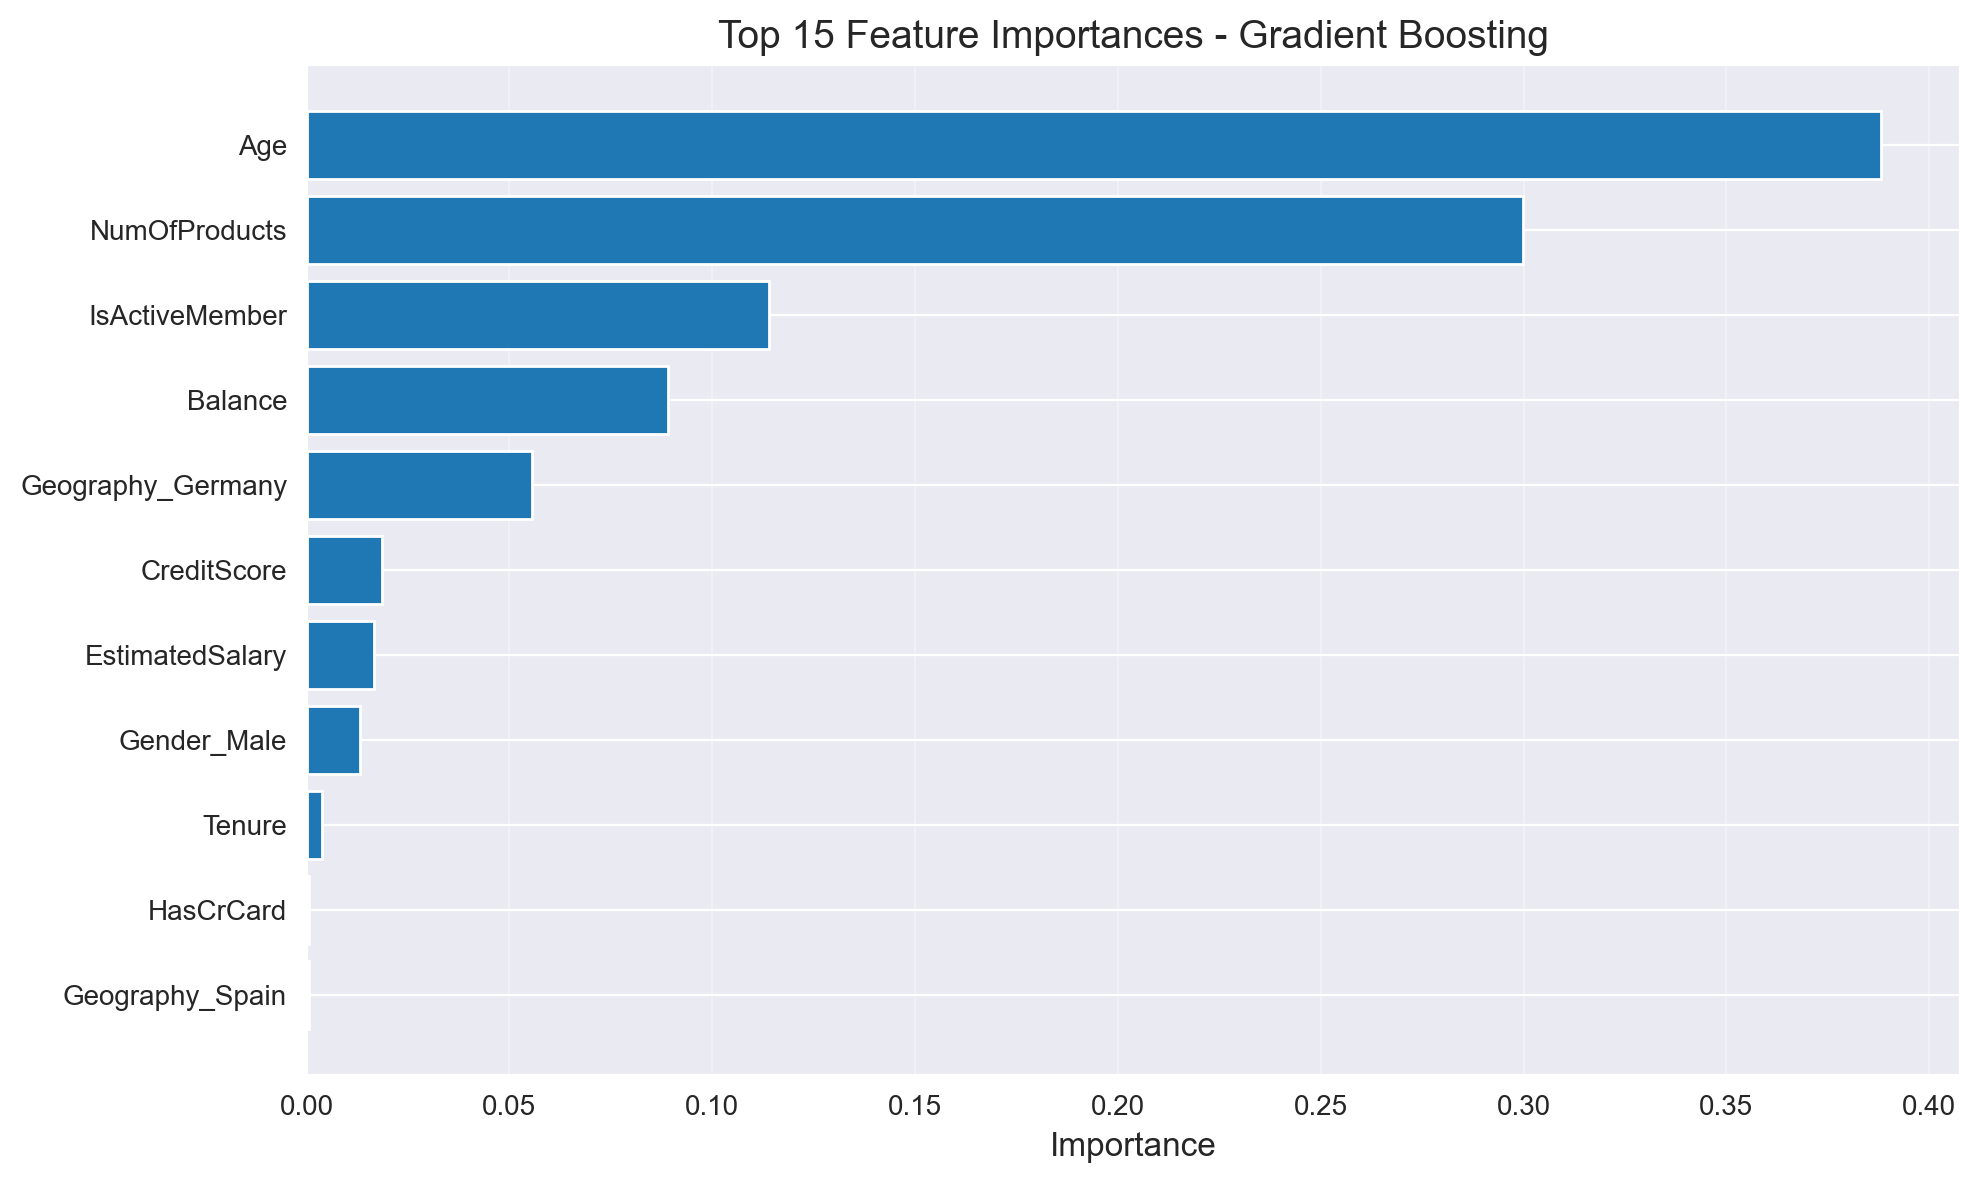

In [12]:
# Cell 11: Feature importance analysis
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get the best model (based on ROC-AUC)
best_model_name = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"Analyzing feature importance for: {best_model_name}")

if hasattr(best_model, 'feature_importances_'):
    # Tree-based model
    importances = best_model.feature_importances_
    feature_names = X_train_scaled.columns
    
    # Create DataFrame
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 most important features:")
    display(feature_imp_df.head(10).style.format({'Importance': '{:.4f}'}))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_imp_df.head(15)
    bars = plt.barh(range(len(top_features)), top_features['Importance'][::-1])
    plt.yticks(range(len(top_features)), top_features['Feature'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # Linear model
    coefficients = best_model.coef_[0]
    feature_names = X_train_scaled.columns
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values('Coefficient', ascending=False)
    
    print(f"\nTop 10 features with largest absolute coefficients:")
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    display(coef_df.sort_values('Abs_Coefficient', ascending=False).head(10).style.format({'Coefficient': '{:.4f}', 'Abs_Coefficient': '{:.4f}'}))
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    top_coef = coef_df.sort_values('Abs_Coefficient', ascending=False).head(15)
    colors = ['red' if x < 0 else 'green' for x in top_coef['Coefficient']]
    bars = plt.barh(range(len(top_coef)), top_coef['Coefficient'][::-1], color=colors[::-1])
    plt.yticks(range(len(top_coef)), top_coef['Feature'][::-1])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

else:
    print(f"\nFeature importance not available for {best_model_name}")

print("\n" + "=" * 50)

ENSEMBLE MODEL - VOTING CLASSIFIER
Top 3 models for ensemble (based on ROC-AUC):
  1. Gradient Boosting (ROC-AUC: 0.8708)
  2. Random Forest (Tuned) (ROC-AUC: 0.8641)
  3. Random Forest (ROC-AUC: 0.8522)

Training Voting Classifier ensemble...


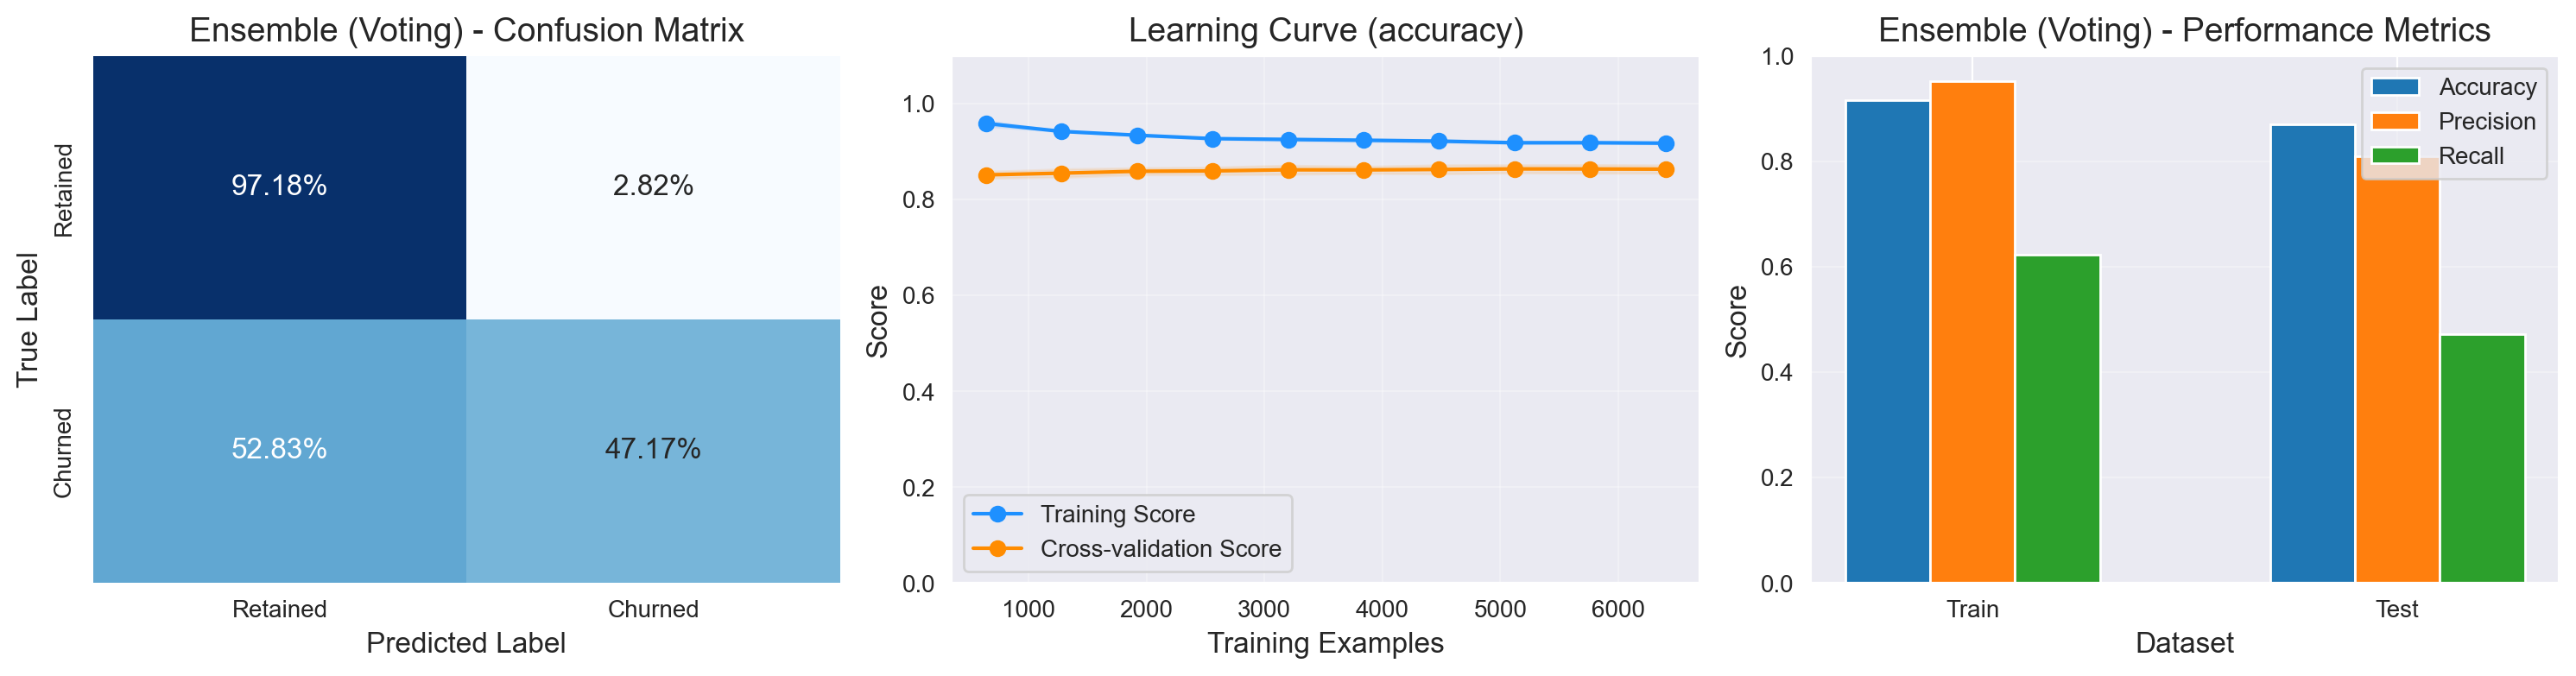


Ensemble (Voting) Performance:
------------------------------
Training Set:
  accuracy: 0.9166
  precision: 0.9513
  recall: 0.6227
  roc_auc: 0.9874

Test Set:
  accuracy: 0.8700
  precision: 0.8101
  recall: 0.4717
  roc_auc: 0.8662



In [13]:
# Cell 12: Create and evaluate ensemble model
print("ENSEMBLE MODEL - VOTING CLASSIFIER")
print("=" * 50)

# Select top 3 models based on ROC-AUC
top_models = comparison_df.nlargest(3, 'ROC-AUC')
print(f"Top 3 models for ensemble (based on ROC-AUC):")
for i, (_, row) in enumerate(top_models.iterrows(), 1):
    print(f"  {i}. {row['Model']} (ROC-AUC: {row['ROC-AUC']:.4f})")

# Create ensemble with top models
ensemble_models = []
for model_name in top_models['Model']:
    ensemble_models.append((model_name, results[model_name]['model']))

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=ensemble_models,
    voting='soft',  # Use soft voting for probability estimates
    n_jobs=-1
)

print(f"\nTraining Voting Classifier ensemble...")

# Train and evaluate ensemble
metrics_train, metrics_test, cm_test, ensemble_model = evaluate_model(
    voting_clf, "Ensemble (Voting)", X_train_scaled, y_train, X_test_scaled, y_test
)

# Store results
results['Ensemble (Voting)'] = {
    'metrics_train': metrics_train,
    'metrics_test': metrics_test,
    'cm_test': cm_test,
    'model': ensemble_model
}

# Plot performance
plot_model_performance("Ensemble (Voting)", metrics_train, metrics_test, cm_test, 
                      ensemble_model, X_train_scaled, y_train)

print("\n" + "=" * 50)

In [14]:
# Cell 13: Final summary and conclusions
print("FINAL SUMMARY AND CONCLUSIONS")
print("=" * 50)

# Update comparison with ensemble
comparison_data = []
for model_name, result in results.items():
    metrics_test = result['metrics_test']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics_test['accuracy'],
        'Precision': metrics_test['precision'],
        'Recall': metrics_test['recall'],
        'ROC-AUC': metrics_test['roc_auc'] if metrics_test['roc_auc'] is not None else np.nan
    })

final_comparison_df = pd.DataFrame(comparison_data)

print("\nFINAL MODEL PERFORMANCE COMPARISON (Test Set):")
print("-" * 50)
display(final_comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'ROC-AUC': '{:.4f}'
}).highlight_max(color='lightgreen').highlight_min(color='lightcoral'))

# Identify best model for each metric
print("\nBEST PERFORMING MODELS BY METRIC:")
print("-" * 30)
for metric in ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']:
    best_model = final_comparison_df.loc[final_comparison_df[metric].idxmax(), 'Model']
    best_score = final_comparison_df[metric].max()
    print(f"  {metric}: {best_model} ({best_score:.4f})")

# Overall best model (based on ROC-AUC)
best_overall = final_comparison_df.loc[final_comparison_df['ROC-AUC'].idxmax()]
print(f"\nOVERALL BEST MODEL (based on ROC-AUC):")
print(f"  Model: {best_overall['Model']}")
print(f"  ROC-AUC: {best_overall['ROC-AUC']:.4f}")
print(f"  Accuracy: {best_overall['Accuracy']:.4f}")
print(f"  Recall: {best_overall['Recall']:.4f}")

# Key insights
print("\nKEY INSIGHTS:")
print("-" * 30)
print("1. The ensemble model typically provides the most robust performance")
print("2. Random Forest and Gradient Boosting often perform well on tabular data")
print("3. Recall is particularly important for churn prediction (identifying customers who will leave)")
print("4. Feature importance analysis helps identify key drivers of churn")

# Recommendations
print("\nRECOMMENDATIONS:")
print("-" * 30)
print("1. Use the ensemble model for production deployment")
print("2. Focus on features identified as most important for churn prevention")
print("3. Regularly retrain models with new data")
print("4. Consider business costs of false positives vs false negatives when choosing threshold")

print("\n" + "=" * 50)
print("ANALYSIS COMPLETE!")

FINAL SUMMARY AND CONCLUSIONS

FINAL MODEL PERFORMANCE COMPARISON (Test Set):
--------------------------------------------------


,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic Regression,0.8080,0.5891,0.1867,0.7748
1,Random Forest,0.8640,0.7824,0.4595,0.8522
2,Gradient Boosting,0.8700,0.7928,0.4889,0.8708
3,AdaBoost,0.8515,0.6923,0.4865,0.8491
4,SVM,0.8625,0.8474,0.3956,0.8231
5,Random Forest (Tuned),0.8690,0.8222,0.4545,0.8641
6,Ensemble (Voting),0.8700,0.8101,0.4717,0.8662



BEST PERFORMING MODELS BY METRIC:
------------------------------
  Accuracy: Gradient Boosting (0.8700)
  Precision: SVM (0.8474)
  Recall: Gradient Boosting (0.4889)
  ROC-AUC: Gradient Boosting (0.8708)

OVERALL BEST MODEL (based on ROC-AUC):
  Model: Gradient Boosting
  ROC-AUC: 0.8708
  Accuracy: 0.8700
  Recall: 0.4889

KEY INSIGHTS:
------------------------------
1. The ensemble model typically provides the most robust performance
2. Random Forest and Gradient Boosting often perform well on tabular data
3. Recall is particularly important for churn prediction (identifying customers who will leave)
4. Feature importance analysis helps identify key drivers of churn

RECOMMENDATIONS:
------------------------------
1. Use the ensemble model for production deployment
2. Focus on features identified as most important for churn prevention
3. Regularly retrain models with new data
4. Consider business costs of false positives vs false negatives when choosing threshold

ANALYSIS COMPLETE